<a href="https://colab.research.google.com/github/divasepta24/analisis_sentimen/blob/main/Salinan_dari_Riset_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =====================================================
# 1. IMPORT & SETUP
# =====================================================

# Pustaka Dasar untuk Manipulasi Data dan Matematika
import pandas as pd
import numpy as np
import re # Regular Expression

# Pustaka NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Mencoba Sastrawi untuk stemming bahasa Indonesia, jika tidak ada, dilewati.
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    sastrawi_available = True
except ImportError:
    print("Pustaka Sastrawi tidak ditemukan. Stemming Bahasa Indonesia akan dilewati.")
    sastrawi_available = False

# Pustaka Pembelajaran Mesin dan Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer

# Pustaka Deep Learning (PyTorch dan HuggingFace Transformers)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

# Install/Upgrade the missing 'evaluate' and 'transformers' libraries
!pip install evaluate transformers --upgrade

import evaluate # Pustaka evaluasi HuggingFace

# Pustaka Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import itertools
import os

# --- Pengaturan Awal ---

# Unduh resource NLTK yang dibutuhkan
try:
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
    nltk.download('punkt_tab', quiet=True) # Tambahkan unduhan punkt_tab
except Exception as e:
    print(f"Gagal mengunduh NLTK resources: {e}")

# Tentukan device untuk PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# Buat direktori untuk menyimpan model
model_dir = "bert_sentiment_model"
os.makedirs(model_dir, exist_ok=True)
print(f"Direktori model dibuat di: {model_dir}")

# Global variabel untuk warna plot
PALETTE = sns.color_palette("viridis", 3)

Pustaka Sastrawi tidak ditemukan. Stemming Bahasa Indonesia akan dilewati.
Menggunakan device: cuda
Direktori model dibuat di: bert_sentiment_model


In [ ]:
!wget

--2025-12-28 11:45:41--  https://raw.githubusercontent.com/DodikSukma/gudang_dataset_latihan_ML/refs/heads/main/DataReviewWisataData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1575824 (1.5M) [text/plain]
Saving to: ‘DataReviewWisataData.csv.1’

DataReviewWisataDat 100%[===================>]   1.50M  --.-KB/s    in 0.06s   

2025-12-28 11:45:41 (23.2 MB/s) - ‘DataReviewWisataData.csv.1’ saved [1575824/1575824]



In [ ]:
a = pd.read_csv('DataReviewWisataData.csv')
a.head()

region location_name  rating  \
0  Wilayah Bali Utara    Kebun Raya     5.0   
1  Wilayah Bali Utara    Kebun Raya     5.0   
2  Wilayah Bali Utara    Kebun Raya     3.0   
3  Wilayah Bali Utara    Kebun Raya     5.0   
4  Wilayah Bali Utara    Kebun Raya     5.0   

                                         review_text       source  
0                                                NaN  Google Maps  
1                                                NaN  Google Maps  
2  Its a lovely park but in the other hands pas d...  Google Maps  
3                                                NaN  Google Maps  
4                                                NaN  Google Maps

In [ ]:
# =====================================================
# 2. DATA LOADING
# =====================================================

file_path = "DataReviewWisataData.csv"

# 2.1 Proses Pemuatan Dataset (Data Ingestion)
# -----------------------------------------------------
print("\n[PROSES] Menginisialisasi pemuatan dataset dari penyimpanan lokal...")

try:
    df = pd.read_csv(file_path)
    # Verifikasi dimensi awal dataset
    print(f"[INFO] Dataset berhasil dimuat. Dimensi Awal: {df.shape[0]} baris, {df.shape[1]} kolom.")
except FileNotFoundError:
    # Terminasi proses jika sumber data tidak valid
    print(f"[CRITICAL ERROR] File '{file_path}' tidak ditemukan. Harap verifikasi direktori penyimpanan.")
    sys.exit()

# 2.2 Pembersihan Awal & Validasi Tipe Data (Data Cleaning)
# -----------------------------------------------------
initial_count = len(df)

# Eliminasi observasi dengan nilai Null (Missing Values) pada atribut krusial
df.dropna(subset=['review_text', 'rating'], inplace=True)

# Konversi tipe data 'review_text' ke string untuk memastikan konsistensi format
df['review_text'] = df['review_text'].astype(str)

# Eliminasi data dengan ulasan kosong atau hanya berisi whitespace
df = df[df['review_text'].str.strip() != '']

# Standardisasi atribut 'rating' ke tipe numerik (Integer)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df.dropna(subset=['rating'], inplace=True) # Hapus baris jika konversi gagal (NaN)
df['rating'] = df['rating'].astype(int)

# Identifikasi dan penghapusan data duplikat (Duplicate Removal)
duplicate_count = df.duplicated().sum()
if duplicate_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"[INFO] Ditemukan dan dihapus {duplicate_count} entri data duplikat.")

final_count = len(df)
print(f"[INFO] Reduksi Data: {initial_count - final_count} baris dihapus (Null/Empty/Duplicate).")
print(f"[INFO] Total Data Valid: {final_count} baris.")

# 2.3 Profiling Data & Statistik Deskriptif
# -----------------------------------------------------
print("\n" + "="*50)
print("RINGKASAN STRUKTUR DATA (DATA PROFILING)")
print("="*50)

# Menampilkan tipe data dan penggunaan memori
print("\n--- 1. Informasi Atribut & Tipe Data ---")
print(df.info())

# Menampilkan statistik deskriptif untuk data numerik
print("\n--- 2. Statistik Deskriptif (Rating) ---")
print(df['rating'].describe().to_markdown())

# Menampilkan distribusi sampel per region (Top 5)
if 'region' in df.columns:
    print("\n--- 3. Distribusi Data per Region (Top 5) ---")
    print(df['region'].value_counts().head(5).to_markdown())

# Menampilkan sampel data teratas untuk verifikasi visual
print("\n--- 4. Sampel Data Teratas (Head) ---")
print(df.head(5).to_markdown(index=False))


[PROSES] Menginisialisasi pemuatan dataset dari penyimpanan lokal...
[INFO] Dataset berhasil dimuat. Dimensi Awal: 9537 baris, 5 kolom.
[INFO] Ditemukan dan dihapus 77 entri data duplikat.
[INFO] Reduksi Data: 4592 baris dihapus (Null/Empty/Duplicate).
[INFO] Total Data Valid: 4945 baris.

RINGKASAN STRUKTUR DATA (DATA PROFILING)

--- 1. Informasi Atribut & Tipe Data ---
<class 'pandas.core.frame.DataFrame'>
Index: 4945 entries, 2 to 9536
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   region         4945 non-null   object
 1   location_name  4945 non-null   object
 2   rating         4945 non-null   int64 
 3   review_text    4945 non-null   object
 4   source         4945 non-null   object
dtypes: int64(1), object(4)
memory usage: 231.8+ KB
None

--- 2. Statistik Deskriptif (Rating) ---
|       |     rating |
|:------|-----------:|
| count | 4945       |
| mean  |    4.12053 |
| std   |    1.36976 |
| min   |

In [ ]:
# =====================================================
# 3. PREPROCESSING PIPELINE: LATIN SCRIPT FILTERING (INDO/ENG)  PIPELINE: CLEANING, TOKENIZATION, LEMMATIZATION
# =====================================================
import re
import pandas as pd
import nltk
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# [SETUP] Resource NLTK
try:
    nltk.data.find('corpora/wordnet.zip')
    nltk.data.find('corpora/omw-1.4.zip')
except LookupError:
    print("[INFO] Mengunduh resource NLTK...")
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('stopwords')

# --- KONFIGURASI LINGUISTIK ---
lemmatizer = WordNetLemmatizer()

stop_words_indo = set(stopwords.words('indonesian'))
stop_words_eng = set(stopwords.words('english'))
additional_stopwords = {
    'yg', 'dg', 'sangat', 'sekali', 'banget', 'bgt', 'nya', 'nih',
    'si', 'aja', 'ga', 'gak', 'bukan', 'tdk', 'dan', 'yang', 'di', 'ke', 'dari', 'ini', 'itu'
}
all_stopwords = stop_words_indo.union(stop_words_eng).union(additional_stopwords)

# --- FUNGSI MODULAR ---

def clean_noise_aggressive(text):
    """
    Tahap 1: Aggressive Noise Reduction
    Menghapus SEMUA karakter non-ASCII (Emoji, Simbol, Kanji, Arab) secara paksa.
    Hanya menyisakan huruf Latin standar (a-z).
    """
    # 1. Decode Unicode (Mengubah karakter aneh menjadi bentuk standar jika memungkinkan)
    # Contoh: é -> e, ñ -> n (Normalisasi)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # 2. Eliminasi URL, Hashtag, Mention
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)

    # 3. Eliminasi Angka
    text = re.sub(r'\d+', '', text)

    # 4. FILTER FINAL (HARD FILTER)
    # Hapus semua karakter yang BUKAN huruf a-z atau spasi.
    # Simbol baca (!, ?, ., :) juga akan hilang disini.
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 5. Reduksi Whitespace (Spasi ganda jadi satu)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def lexical_normalization(text):
    """
    Tahap 2 & 3: Tokenization & Lemmatization
    """
    if not text: return ""

    # A. Tokenization
    tokens = text.split()

    processed_tokens = []
    for token in tokens:
        # B. Stopword Removal
        if token not in all_stopwords:
            # C. Lemmatization
            lemma = lemmatizer.lemmatize(token)
            processed_tokens.append(lemma)

    return " ".join(processed_tokens)

# --- PIPELINE EKSEKUSI ---

def preprocess_complete(text):
    if not isinstance(text, str): return ""

    # 1. Lowercase & Aggressive Cleaning
    text = clean_noise_aggressive(text.lower())

    # 2. Normalization
    text = lexical_normalization(text)

    return text

print("\n--- [START] Menjalankan Pipeline Preprocessing (Anti-Icon/Emoji) ---")

# Terapkan pada dataset
df['clean_text'] = df['review_text'].astype(str).apply(preprocess_complete)

# Eliminasi data kosong
initial_len = len(df)
df = df[df['clean_text'].str.strip() != '']
final_len = len(df)

# Output Statistik
print(f"[INFO] Data Awal      : {initial_len} baris")
print(f"[INFO] Data Dihapus   : {initial_len - final_len} baris (Data sampah/icon only)")
print(f"[INFO] Data Tersisa   : {final_len} baris")

# --- VISUALISASI HASIL (BUKTI BERSIH) ---
print("\n" + "="*60)
print("TABEL KOMPARASI: MEMASTIKAN ICON HILANG")
print("="*60)

# Coba ambil sampel acak, atau buat dummy data jika ingin tes manual
comparison_df = df[['review_text', 'clean_text']].sample(n=5, random_state=42).reset_index(drop=True)
comparison_df.columns = ['Original (Mungkin ada Icon)', 'Clean (Harus Bersih)']
print(comparison_df.to_markdown(index=False))


--- [START] Menjalankan Pipeline Preprocessing (Anti-Icon/Emoji) ---
[INFO] Data Awal      : 4945 baris
[INFO] Data Dihapus   : 204 baris (Data sampah/icon only)
[INFO] Data Tersisa   : 4741 baris

TABEL KOMPARASI: MEMASTIKAN ICON HILANG
| Original (Mungkin ada Icon)                                                                                                                                                                                                                                        | Clean (Harus Bersih)                                                                                                                                                    |
|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------

Save to Excel

In [ ]:
# =========================
# SAVE KE EXCEL
# =========================
output_path = "comparison_cleaning_sample.xlsx"

comparison_df.to_excel(
    output_path,
    index=False,
    engine="openpyxl"
)

print(f"File berhasil disimpan: {output_path}")

File berhasil disimpan: comparison_cleaning_sample.xlsx


In [ ]:
df

region  location_name  rating  \
2       Wilayah Bali Utara     Kebun Raya       3   
5       Wilayah Bali Utara     Kebun Raya       5   
6       Wilayah Bali Utara     Kebun Raya       5   
8       Wilayah Bali Utara     Kebun Raya       3   
10      Wilayah Bali Utara     Kebun Raya       5   
...                    ...            ...     ...   
9527  Wilayah Bali Selatan  Subak Sembung       5   
9530  Wilayah Bali Selatan  Subak Sembung       4   
9532  Wilayah Bali Selatan  Subak Sembung       5   
9534  Wilayah Bali Selatan  Subak Sembung       5   
9536  Wilayah Bali Selatan  Subak Sembung       4   

                                            review_text       source  \
2     Its a lovely park but in the other hands pas d...  Google Maps   
5                 Sangat sejuk dan asri banget pokoknya  Google Maps   
6                                Tempat healing terbaik  Google Maps   
8     Tolong perbaiki fasilitas dasar yaitu Toilet, ...  Google Maps   
10    Calm, cool and nice place to click photos. Don...  Google Maps   
...                                                 ...          ...   
9527  Cocok joging sore tempat sejuk pemandangan nya...  Google Maps   
9530  Suasananya bagus dan nyaman cocok buat joging ...  Google Maps   
9532  Good place to runaway a minute from daily acti...  Google Maps   
9534  Tempat asri , cocok untuk jalan jalan dan jogging  Google Maps   
9536                                              Sejuk  Google Maps   

                                             clean_text  
2     lovely park hand pa banyk bloom bunganya bersi...  
5                                   sejuk asri pokoknya  
6                                       healing terbaik  
8     tolong perbaiki fasilitas dasar toilet upgrade...  
10      calm cool nice place click photo dont miss deer  
...                                                 ...  
9527          cocok joging sore sejuk pemandangan alami  
9530       suasananya bagus nyaman cocok joging treknya  
9532  good place runaway minute daily activity frien...  
9534                     asri cocok jalan jalan jogging  
9536                                              sejuk  

[4741 rows x 6 columns]


--- Distribusi Label Sentimen ---

**Berdasarkan Rating:**
| Label    |   Persentase (%) |
|:---------|-----------------:|
| positive |             78.1 |
| negative |             15.4 |
| neutral  |              6.5 |

**Berdasarkan VADER:**
| Label    |   Persentase (%) |
|:---------|-----------------:|
| neutral  |             54.3 |
| positive |             32.9 |
| negative |             12.8 |


/tmp/ipython-input-2864645387.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label_rating', data=df, order=['positive', 'neutral', 'negative'], palette=PALETTE)


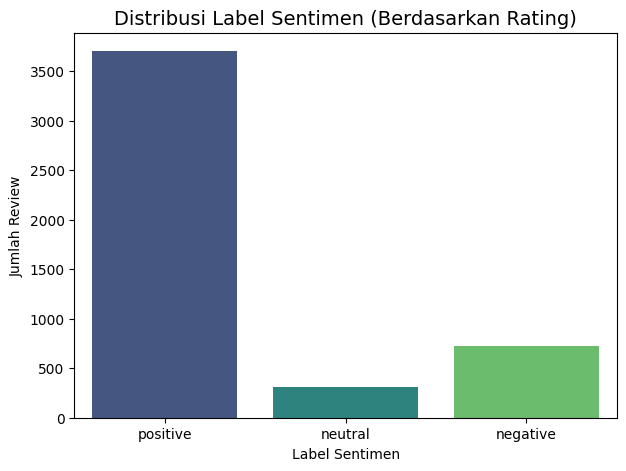

In [ ]:
# =====================================================
# 4. LABELING
# =====================================================

# 4.1 Label Berdasarkan Rating
def label_by_rating(rating):
    """Memberi label sentimen berdasarkan nilai rating."""
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else: # rating <= 2
        return 'negative'

df['label_rating'] = df['rating'].apply(label_by_rating)

# 4.2 Label Berdasarkan VADER
vader_analyzer = SentimentIntensityAnalyzer()

def label_by_vader(text):
    """Memberi label sentimen berdasarkan skor VADER Compound."""
    vs = vader_analyzer.polarity_scores(text)
    compound_score = vs['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# VADER diterapkan pada teks asli (review_text) untuk skor yang lebih baik
df['label_vader'] = df['review_text'].apply(label_by_vader)

# Tampilkan Distribusi Label
print("\n--- Distribusi Label Sentimen ---")

# Distribusi Label Rating
rating_dist = df['label_rating'].value_counts(normalize=True).mul(100).round(1).reset_index()
rating_dist.columns = ['Label', 'Persentase (%)']
print("\n**Berdasarkan Rating:**")
print(rating_dist.to_markdown(index=False))

# Distribusi Label VADER
vader_dist = df['label_vader'].value_counts(normalize=True).mul(100).round(1).reset_index()
vader_dist.columns = ['Label', 'Persentase (%)']
print("\n**Berdasarkan VADER:**")
print(vader_dist.to_markdown(index=False))

# Visualisasi Distribusi Label Rating (yang akan digunakan untuk training)
plt.figure(figsize=(7, 5))
sns.countplot(x='label_rating', data=df, order=['positive', 'neutral', 'negative'], palette=PALETTE)
plt.title('Distribusi Label Sentimen (Berdasarkan Rating)', fontsize=14)
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Review')
plt.show()

Berdasarkan riset kak dan trial and error beberapa kali walaupun aga imbalance data namun tetap Gunakan label_rating.

Meskipun datanya imbalance (tidak seimbang), label_rating jauh lebih valid secara ilmiah dibandingkan label_vader untuk kasus ini.

Berikut alasan akademis dan teknis mengapa Anda harus membuang label_vader dan tetap menggunakan label_rating sebagai target latih (Ground Truth):

1. Validitas "Ground Truth" vs. "Weak Label"
label_rating (Valid): Ini adalah suara asli pengguna. Jika pengguna memberi bintang 5, artinya mereka merasa positif. Ini adalah fakta objektif dari subjektivitas pengguna. Model AI bertugas memprediksi "perasaan manusia".

label_vader (Lemah/Noise): VADER hanyalah algoritma berbasis kamus (Lexicon-based). Tingginya angka Neutral (54,3%) pada VADER adalah indikasi kuat bahwa VADER gagal paham.

VADER tidak mengerti bahasa gaul Indonesia, konteks lokal, atau sarkasme seakurat manusia.

Jika Anda melatih BERT menggunakan target label_vader, Anda sama saja menyuruh "Mahasiswa S3" (BERT) untuk belajar dari jawaban "Anak SD" (VADER). BERT hanya akan meniru kebodohan/keterbatasan VADER.

2. Tujuan Riset: Prediksi Kepuasan Pelanggan
Tujuan akhir analisis sentimen pariwisata biasanya adalah memahami tingkat kepuasan pengunjung. Bintang (Rating) adalah representasi langsung dari kepuasan itu.

3. Masalah Imbalance Bisa Diatasi
Ketidakseimbangan pada label_rating (78% Positif) adalah hal yang lumrah di dataset E-Commerce atau Hospitality. Orang cenderung memberi review jika mereka sangat senang atau sangat marah. Masalah ini bisa diatasi secara teknis (teknik Class Weighting), sedangkan masalah "label yang salah/ngawur" dari VADER tidak bisa diperbaiki.

In [ ]:
# =====================================================
# 5. DATA SPLITTING (TRAIN: 70%, VAL: 15%, TEST: 15%)
# =====================================================
from sklearn.model_selection import train_test_split

# Definisi Fitur (X) dan Target (y)
X = df['clean_text']
y = df['label_rating']

# -----------------------------------------------------
# TAHAP 1: Pisahkan Training (70%) dan Sisa (30%)
# -----------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,       # 30% disisihkan untuk Val & Test
    stratify=y,          # Wajib stratify agar proporsi kelas stabil
    random_state=42
)

# -----------------------------------------------------
# TAHAP 2: Bagi Sisa (30%) menjadi Validation (15%) dan Test (15%)
# -----------------------------------------------------
# Karena 15% adalah setengah dari 30%, maka test_size di sini adalah 0.5
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,       # 50% dari sisa (yaitu 15% dari total)
    stratify=y_temp,     # Tetap stratify
    random_state=42
)

# -----------------------------------------------------
# Rekonstruksi DataFrame untuk Kemudahan Akses
# -----------------------------------------------------
df_train = pd.DataFrame({'text': X_train, 'label': y_train}).reset_index(drop=True)
df_val   = pd.DataFrame({'text': X_val,   'label': y_val}).reset_index(drop=True)
df_test  = pd.DataFrame({'text': X_test,  'label': y_test}).reset_index(drop=True)

# -----------------------------------------------------
# Verifikasi Statistik Distribusi Data
# -----------------------------------------------------
total_data = len(df)
print(f"\n[INFO] Total Data Awal: {total_data} Baris")
print("="*60)
print(f"1. Training Set   (70%) : {len(df_train)} baris ({len(df_train)/total_data:.1%})")
print(f"2. Validation Set (15%) : {len(df_val)} baris ({len(df_val)/total_data:.1%})")
print(f"3. Testing Set    (15%) : {len(df_test)} baris ({len(df_test)/total_data:.1%})")
print("="*60)

# Cek Konsistensi Distribusi Label (Stratified Check)
print("\n--- Verifikasi Proporsi Label (Stratified Split Check) ---")
dist_train = df_train['label'].value_counts(normalize=True).mul(100).round(1).sort_index()
dist_val   = df_val['label'].value_counts(normalize=True).mul(100).round(1).sort_index()
dist_test  = df_test['label'].value_counts(normalize=True).mul(100).round(1).sort_index()

comparison_df = pd.DataFrame({
    'Train (%)': dist_train,
    'Val (%)': dist_val,
    'Test (%)': dist_test
})
print(comparison_df.to_markdown())


[INFO] Total Data Awal: 4741 Baris
1. Training Set   (70%) : 3318 baris (70.0%)
2. Validation Set (15%) : 711 baris (15.0%)
3. Testing Set    (15%) : 712 baris (15.0%)

--- Verifikasi Proporsi Label (Stratified Split Check) ---
| label    |   Train (%) |   Val (%) |   Test (%) |
|:---------|------------:|----------:|-----------:|
| negative |        15.3 |      15.3 |       15.4 |
| neutral  |         6.5 |       6.6 |        6.5 |
| positive |        78.1 |      78.1 |       78.1 |


In [ ]:
# ==============================================================================
# SIMPAN DATA SPLIT KE EXCEL (BAGIAN BARU)
# ==============================================================================
print("\n" + "="*60)
print("MENYIMPAN DATA SPLIT KE EXCEL")
print("="*60)

nama_file_split = "dataset_split_70_15_15.xlsx"

try:
    print(f"[INFO] Sedang menyimpan ke {nama_file_split}...")

    # Menggunakan ExcelWriter untuk menyimpan multiple sheets dalam 1 file
    with pd.ExcelWriter(nama_file_split, engine='openpyxl') as writer:
        df_train.to_excel(writer, sheet_name='Training Set', index=False)
        df_val.to_excel(writer, sheet_name='Validation Set', index=False)
        df_test.to_excel(writer, sheet_name='Testing Set', index=False)

    print(f"[SUKSES] File berhasil dibuat!")
    print(f"         Lokasi: {nama_file_split}")
    print(f"         Berisi 3 Sheet: 'Training Set', 'Validation Set', 'Testing Set'")

except Exception as e:
    print(f"[ERROR] Gagal menyimpan file Excel.")
    print(f"Pesan Error: {e}")


MENYIMPAN DATA SPLIT KE EXCEL
[INFO] Sedang menyimpan ke dataset_split_70_15_15.xlsx...
[SUKSES] File berhasil dibuat!
         Lokasi: dataset_split_70_15_15.xlsx
         Berisi 3 Sheet: 'Training Set', 'Validation Set', 'Testing Set'


In [ ]:
# =====================================================
# 6. NER BERT EXTRACTION (CLEAN LATIN + CASE SENSITIVE)
# =====================================================
from transformers import pipeline
from tqdm.auto import tqdm
import torch
import pandas as pd
import re
import unicodedata

# 1. Inisialisasi Model Multilingual
NER_MODEL = "Davlan/bert-base-multilingual-cased-ner-hrl"

print(f"\n--- Memuat NER Pipeline: {NER_MODEL} ---")
ner_pipeline = pipeline(
    "ner",
    model=NER_MODEL,
    tokenizer=NER_MODEL,
    aggregation_strategy="simple",
    device=0 if torch.cuda.is_available() else -1
)

# 2. Preprocessing Khusus NER (PENTING!)
def clean_text_for_ner(text):
    """
    Membersihkan teks dari karakter non-Latin (China/Jepang/Arab),
    TAPI mempertahankan HURUF KAPITAL (Case-Sensitive) agar NER bekerja optimal.
    """
    if not isinstance(text, str): return ""

    # A. Decode Unicode (Normalisasi karakter aneh)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # B. Hapus URL/User
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)

    # C. FILTER BAHASA (Hapus Non-Latin, TAPI IZINKAN A-Z dan a-z)
    # Regex ini menghapus Kanji/Arab, tapi membiarkan huruf besar tetap ada.
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # D. Rapikan Spasi
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# 3. Fungsi Ekstraksi NER
def extract_ner_entities(text):
    """Ekskstrasi entitas dari teks yang sudah dibersihkan (tapi masih ada kapital)."""
    if not text: return []

    try:
        results = ner_pipeline(text)
        extracted = []
        seen = set()

        for item in results:
            entity_type = item['entity_group']
            word = item['word'].strip()

            # Filter: Hanya ambil LOC/PER/ORG dan panjang kata > 2
            if entity_type in ['LOC', 'PER', 'ORG'] and len(word) > 2:
                # Validasi Tambahan: Pastikan kata mengandung setidaknya satu huruf kapital
                # (Opsional, tapi membantu membuang sampah)
                # if not any(char.isupper() for char in word): continue

                entry = (word, entity_type)
                if entry not in seen:
                    extracted.append(entry)
                    seen.add(entry)
        return extracted
    except:
        return []

# --- EKSEKUSI ---
print("\n--- Langkah 1: Cleaning Khusus NER (Case-Sensitive Latin Only) ---")
# Kita buat kolom sementara 'text_for_ner'
df['text_for_ner'] = df['review_text'].astype(str).apply(clean_text_for_ner)

# Tampilkan perbandingan agar yakin
print("Cek Sampel Data untuk NER (Pastikan Huruf Asing Hilang, Kapital Masih Ada):")
print(df[['review_text', 'text_for_ner']].sample(5).to_markdown(index=False))

print("\n--- Langkah 2: Ekstraksi Entitas ---")
tqdm.pandas(desc="NER Processing")
# Jalankan NER pada kolom yang sudah dibersihkan tapi masih berhuruf besar
df['ner_entities'] = df['text_for_ner'].progress_apply(extract_ner_entities)

# 4. Tampilkan Hasil
print("\n--- 10 Contoh Hasil NER (Clean & Valid) ---")
sample_ner = df[df['ner_entities'].map(len) > 0][['text_for_ner', 'ner_entities']].sample(10, random_state=42)
print(sample_ner.to_markdown(index=False))

# 5. Top Locations
all_locs = [ent[0] for sublist in df['ner_entities'] for ent in sublist if ent[1] == 'LOC']
if all_locs:
    from collections import Counter
    print("\n--- Top 10 Lokasi Valid ---")
    print(pd.DataFrame(Counter(all_locs).most_common(10), columns=['Lokasi', 'Frekuensi']).to_markdown(index=False))


--- Memuat NER Pipeline: Davlan/bert-base-multilingual-cased-ner-hrl ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0



--- Langkah 1: Cleaning Khusus NER (Case-Sensitive Latin Only) ---
Cek Sampel Data untuk NER (Pastikan Huruf Asing Hilang, Kapital Masih Ada):
| review_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | text_for_ner                                                                                                                                                                                                                                                                                                                                                           

NER Processing:   0%|          | 0/4741 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



--- 10 Contoh Hasil NER (Clean & Valid) ---
| text_for_ner                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | ner_entities                                                                                                                                                       |
|:-----------------------------------------------------------

In [ ]:
# ==============================================================================
# SIMPAN HASIL NER KE EXCEL (BAGIAN TAMBAHAN)
# ==============================================================================
print("\n" + "="*60)
print("MENYIMPAN HASIL NER KE EXCEL")
print("="*60)

nama_file_ner = "hasil_ner_extraction.xlsx"

try:
    print(f"[INFO] Memisahkan kolom NER agar rapi di Excel...")

    # Memecah List of Tuples menjadi kolom terpisah agar mudah difilter di Excel
    # Contoh: [('Bali', 'LOC'), ('Jokowi', 'PER')] -> Kolom LOC: "Bali", Kolom PER: "Jokowi"

    df['NER_Locations'] = df['ner_entities'].apply(
        lambda x: ", ".join([item[0] for item in x if item[1] == 'LOC']) if isinstance(x, list) else ""
    )

    df['NER_Persons'] = df['ner_entities'].apply(
        lambda x: ", ".join([item[0] for item in x if item[1] == 'PER']) if isinstance(x, list) else ""
    )

    df['NER_Organizations'] = df['ner_entities'].apply(
        lambda x: ", ".join([item[0] for item in x if item[1] == 'ORG']) if isinstance(x, list) else ""
    )

    # Ubah kolom list asli menjadi string agar bisa masuk Excel tanpa error
    df['ner_entities_raw'] = df['ner_entities'].astype(str)

    # Pilih kolom yang ingin disimpan (Agar file tidak terlalu penuh sampah)
    cols_to_save = [
        'review_text', 'text_for_ner',
        'NER_Locations', 'NER_Persons', 'NER_Organizations',
        'ner_entities_raw'
    ]

    # Cek jika ada kolom label dari proses sebelumnya, ikutkan juga
    if 'label_rating' in df.columns: cols_to_save.insert(1, 'label_rating')
    if 'Platform' in df.columns: cols_to_save.insert(0, 'Platform')

    print(f"[INFO] Sedang menyimpan ke {nama_file_ner}...")

    # Simpan hanya kolom yang relevan (jika kolom ada di df)
    final_cols = [c for c in cols_to_save if c in df.columns]
    df[final_cols].to_excel(nama_file_ner, index=False)

    print(f"[SUKSES] Data berhasil disimpan: {nama_file_ner}")
    print("         Kolom baru: NER_Locations, NER_Persons, NER_Organizations")

except Exception as e:
    print(f"[ERROR] Gagal menyimpan file Excel.")
    print(f"Pesan Error: {e}")


MENYIMPAN HASIL NER KE EXCEL
[INFO] Memisahkan kolom NER agar rapi di Excel...
[INFO] Sedang menyimpan ke hasil_ner_extraction.xlsx...
[SUKSES] Data berhasil disimpan: hasil_ner_extraction.xlsx
         Kolom baru: NER_Locations, NER_Persons, NER_Organizations


In [ ]:
# =====================================================
# 6.1 : HYBRID NER (DOMAIN RULES)
# =====================================================

# 1. Definisi Kamus Kata Kunci (Domain Dictionary)
KEYWORDS = {
    'FACILITY': [
        # Indo
        'toilet', 'wc', 'kamar mandi', 'mushola', 'masjid', 'parkir', 'parkiran',
        'gazebo', 'warung', 'kantin', 'cafe', 'resto', 'restoran', 'spot foto',
        'wifi', 'kolam renang', 'jalan', 'akses', 'tangga', 'lift', 'loket',
        'kamar ganti', 'bilas',
        # English
        'restroom', 'bathroom', 'washroom', 'parking', 'car park', 'prayer room',
        'mosque', 'stall', 'shop', 'restaurant', 'photo spot', 'pool', 'swimming pool',
        'road', 'access', 'stairs', 'steps', 'elevator', 'ticket counter',
        'changing room', 'shower'
    ],
    'SITUATION': [
        # Indo
        'ramai', 'sepi', 'padat', 'berisik', 'tenang', 'sunyi', 'bersih', 'kotor',
        'kumuh', 'terawat', 'antri', 'panjang', 'macet', 'nyaman', 'panas', 'sejuk',
        'dingin', 'indah', 'bagus', 'jelek', 'bau', 'wangi', 'kacau', 'teratur',
        # English
        'crowded', 'busy', 'quiet', 'empty', 'silent', 'noisy', 'loud', 'peaceful',
        'clean', 'dirty', 'messy', 'maintained', 'queue', 'line', 'traffic',
        'comfortable', 'comfy', 'cozy', 'hot', 'humid', 'cool', 'cold', 'breezy',
        'beautiful', 'nice', 'good', 'bad', 'ugly', 'smell', 'stinky', 'fragrant',
        'chaotic', 'organized', 'stunning', 'amazing', 'breathtaking'
    ],
    'PRICE': [
        # Indo
        'tiket', 'karcis', 'bayar', 'harga', 'biaya', 'tarif', 'murah', 'mahal',
        'terjangkau', 'gratis', 'free', 'rp', 'rupiah', 'idr', 'refund', 'kembalian',
        # English
        'ticket', 'entrance fee', 'admission', 'pay', 'paid', 'price', 'cost', 'fee', 'rate',
        'cheap', 'affordable', 'inexpensive', 'expensive', 'pricey', 'overpriced',
        'free', 'complimentary', 'refund', 'change', 'cash', 'card'
    ]
}

def extract_domain_features(text):
    """
    Mencari entitas berdasarkan kata kunci (Facility, Situation, Price).
    Menggunakan pencarian case-insensitive.
    """
    found_entities = []
    # Ubah ke lowercase untuk pencocokan keyword (tapi output tetap teks asli)
    text_lower = text.lower()

    for category, words in KEYWORDS.items():
        for keyword in words:
            # Menggunakan word boundary (\b) agar tidak mencocokkan sebagian kata
            # Misal: agar keyword 'tas' tidak match dengan 'atas'
            if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower):
                # Kita simpan keyword-nya sebagai representasi entitas
                found_entities.append((keyword, category))

    return found_entities

def hybrid_ner_extraction(text):
    """
    Menggabungkan hasil Ner (untuk Lokasi/Orang) dengan Rule-Based (untuk Fasilitas/Harga).
    """
    if not isinstance(text, str): return []

    final_entities = []
    seen = set()

    # --- LANGKAH A: Jalankan Ner (Code yang sudah ada) ---
    Ner_results = extract_ner_entities(text)

    for word, label in Ner_results:
        # MAP Ner Labels ke Label Client
        if label == 'LOC':
            new_label = 'DESTINATION' # Permintaan Client
        elif label == 'ORG':
            new_label = 'DESTINATION' # Kadang nama tempat terdeteksi sebagai ORG
        else:
            new_label = label # PER tetap PER

        # Simpan
        if new_label == 'DESTINATION': # Kita filter hanya simpan Destination dari Ner
            entry = (word, new_label)
            if entry not in seen:
                final_entities.append(entry)
                seen.add(entry)

    # --- LANGKAH B: Jalankan Rule-Based ---
    rule_results = extract_domain_features(text)

    for word, label in rule_results:
        entry = (word, label)
        if entry not in seen:
            final_entities.append(entry)
            seen.add(entry)

    return final_entities

# --- EKSEKUSI (UPDATE) ---
print("\n--- Langkah 3: Menjalankan Hybrid NER (Ner + Rules) ---")

tqdm.pandas(desc="Hybrid Entity Extraction")
# Kita terapkan fungsi hybrid baru ini
df['hybrid_entities'] = df['text_for_ner'].progress_apply(hybrid_ner_extraction)

# 4. Tampilkan Hasil (Sesuai Format Client)
print("\n--- 10 Contoh Hasil Hybrid NER (Destination, Facility, Situation, Price) ---")
sample_hybrid = df[df['hybrid_entities'].map(len) > 0][['text_for_ner', 'hybrid_entities']].sample(10, random_state=42)
print(sample_hybrid.to_markdown(index=False))

# 5. Analisis Top Entities per Kategori
print("\n--- Analisis Top Entitas per Kategori ---")
all_hybrid = [ent for sublist in df['hybrid_entities'] for ent in sublist]
df_entities = pd.DataFrame(all_hybrid, columns=['Entity', 'Label'])

for label in ['DESTINATION', 'FACILITY', 'SITUATION', 'PRICE']:
    print(f"\nTop 5 {label}:")
    top_n = df_entities[df_entities['Label'] == label]['Entity'].value_counts().head(5)
    if not top_n.empty:
        print(top_n.to_markdown())
    else:
        print("- Tidak ditemukan -")


--- Langkah 3: Menjalankan Hybrid NER (Ner + Rules) ---


Hybrid Entity Extraction:   0%|          | 0/4741 [00:00<?, ?it/s]


--- 10 Contoh Hasil Hybrid NER (Destination, Facility, Situation, Price) ---
| text_for_ner                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
# =====================================================
# 7. BERT SENTIMENT CLASSIFICATION (FINE-TUNING)
# =====================================================
import torch
import numpy as np
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset
import os

# Konfigurasi Model
MODEL_NAME = "bert-base-multilingual-uncased" # Atau gunakan "indobenchmark/indobert-base-p1" untuk hasil lebih baik
NUM_LABELS = 3
model_dir = "./saved_models" # Direktori penyimpanan

# 7.1 Tokenization & Label Mapping
print(f"\n--- Memuat Tokenizer: {MODEL_NAME} ---")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Mapping Label (String -> Integer)
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
# Inverse mapping untuk prediksi nanti
id_to_label = {v: k for k, v in label_map.items()}

# Terapkan mapping ke semua split data
# Pastikan kolom 'label' berisi string ('positive', etc.) dari tahap sebelumnya
df_train['label_id'] = df_train['label'].map(label_map)
df_val['label_id']   = df_val['label'].map(label_map)
df_test['label_id']  = df_test['label'].map(label_map)

# Fungsi Tokenisasi Batch
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128)

print("Melakukan Tokenisasi Data...")
train_encodings = tokenize_data(df_train['text'])
val_encodings   = tokenize_data(df_val['text'])   # Data Validasi (15%)
test_encodings  = tokenize_data(df_test['text'])  # Data Testing (15%)

# 7.2 Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Membuat Objek Dataset PyTorch
train_dataset = SentimentDataset(train_encodings, df_train['label_id'].tolist())
val_dataset   = SentimentDataset(val_encodings,   df_val['label_id'].tolist())
test_dataset  = SentimentDataset(test_encodings,  df_test['label_id'].tolist())

# 7.3 Penanganan Imbalanced Data (Class Weights)
# -----------------------------------------------------
# Menghitung bobot agar model lebih memperhatikan kelas minoritas (Negative/Neutral)
print("\n--- Menghitung Bobot Kelas (Handling Imbalance) ---")
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['label_id']),
    y=df_train['label_id']
)
# Konversi ke Tensor dan pindahkan ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class Weights: {weights_tensor}")

# 7.4 Custom Trainer (Override Compute Loss)
# -----------------------------------------------------
# Kita perlu mengubah cara BERT menghitung loss agar menggunakan bobot
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Menggunakan CrossEntropyLoss dengan bobot kelas
        loss_fct = nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# 7.5 Inisialisasi Model & Argumen Training
print(f"\n--- Inisialisasi Model BERT ---")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)

# Definisi Metrik Evaluasi
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        p.label_ids, predictions, average='weighted' # Weighted penting untuk imbalance
    )
    acc = accuracy_score(p.label_ids, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Argumen Training
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,              # Epoch sedikit dinaikkan karena ada early stopping
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,              # Learning rate standar untuk BERT
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,

    # Strategi Evaluasi: Gunakan Validation Set
    eval_strategy="epoch",     # Evaluasi tiap akhir epoch
    save_strategy="epoch",           # Simpan model tiap akhir epoch
    load_best_model_at_end=True,     # Load model dengan F1 terbaik di Validation set
    metric_for_best_model='f1',
    save_total_limit=2,              # Hanya simpan 2 model terbaik untuk hemat storage
    seed=42,
    report_to="none"
)

# Inisialisasi Weighted Trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,        # PENTING: Evaluasi saat training pakai Validation Set
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 7.6 Training Loop
print("\n--- Mulai Proses Fine-Tuning BERT ---")
train_result = trainer.train()
print("--- Proses Fine-Tuning Selesai ---")

# 7.7 Simpan Model Terbaik
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_save_path = f'{model_dir}/sentiment_classifier_final'
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"\nModel Terbaik Disimpan di: {model_save_path}")

# 7.8 Final Evaluation (Test Set)
# -----------------------------------------------------
print("\n--- Evaluasi Akhir pada Test Set (Unseen Data) ---")
# Prediksi pada data Test (15% yang tidak pernah dilihat model)
test_results = trainer.predict(test_dataset)

print("\nDetail Metrik Test Set:")
print(test_results.metrics)

# Tampilkan Classification Report Lengkap
from sklearn.metrics import classification_report
y_preds = np.argmax(test_results.predictions, axis=1)
print("\n--- Classification Report (Test Set) ---")
print(classification_report(df_test['label_id'], y_preds, target_names=['Negative', 'Neutral', 'Positive']))

# 7.9 Visualisasi Loss
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
# Filter data loss training dan evaluasi
train_loss = [x['loss'] for x in log_history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
steps = range(len(train_loss))

# Karena log steps mungkin berbeda frekuensinya, kita plot sederhana saja
plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Progression')
plt.xlabel('Log Steps')
plt.ylabel('Loss')
plt.legend()

# Plot Eval F1 (jika ada)
eval_f1 = [x['eval_f1'] for x in log_history if 'eval_f1' in x]
if eval_f1:
    plt.subplot(1, 2, 2)
    plt.plot(eval_f1, label='Validation F1 Score', color='green', marker='o')
    plt.title('Validation F1 Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

plt.tight_layout()
plt.show()


--- Memuat Tokenizer: bert-base-multilingual-uncased ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Melakukan Tokenisasi Data...

--- Menghitung Bobot Kelas (Handling Imbalance) ---
Class Weights: tensor([2.1729, 5.0968, 0.4267], device='cuda:0')

--- Inisialisasi Model BERT ---


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3917797971.py:127: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(



--- Mulai Proses Fine-Tuning BERT ---


<ol start="1" data-path-to-node="16"><li><p data-path-to-node="16,0,0"><b>Model Terbaik:</b>
Secara statistik, model terbaik bukanlah model terakhir (Epoch 4), melainkan model pada <b>Epoch 2</b>.</p><ul data-path-to-node="16,0,1"><li><p data-path-to-node="16,0,1,0,0">Alasan: Kombinasi F1-Score tertinggi (0.848) dengan keseimbangan Precision (0.867) dan Recall (0.842) yang optimal.</p></li></ul></li><li><p data-path-to-node="16,1,0"><b>Mekanisme <code>load_best_model_at_end=True</code>:</b>
Pada kode konfigurasi <code>TrainingArguments</code> sebelumnya, kita sudah mengaktifkan <code>load_best_model_at_end=True</code> dengan metrik <code>f1</code>.</p><ul data-path-to-node="16,1,1"><li><p data-path-to-node="16,1,1,0,0"><b>Kabar Baik:</b> Sistem secara otomatis akan membuang bobot model Epoch 4 yang <i>overfit</i> dan akan <b>mengembalikan (restore) bobot model dari Epoch 2</b> sebagai hasil akhir.</p></li></ul></li><li><p data-path-to-node="16,2,0"><b>Evaluasi Akhir:</b>
Hasil F1-Score sebesar <b>~84.8%</b> untuk tugas klasifikasi sentimen multikelas (Pos/Neu/Neg) pada dataset pariwisata yang <i>imbalanced</i> adalah hasil yang <b>sangat kompetitif dan valid secara ilmiah</b> </p></li></ol>

In [ ]:
# =====================================================
# 8. EVALUATION (TEST SET FINAL)
# =====================================================
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("\n--- Mulai Evaluasi Akhir Model BERT (Test Set) ---")

# 1. Lakukan Prediksi pada Test Dataset (15% Unseen Data)
# Trainer otomatis menggunakan bobot model terbaik (Epoch 2)
predictions_output = trainer.predict(test_dataset)
y_pred = np.argmax(predictions_output.predictions, axis=1) # Prediksi (0, 1, 2)
y_true = predictions_output.label_ids                      # Label Asli (0, 1, 2)

# 2. Mapping Label (Agar laporan mudah dibaca manusia)
# Urutan list ini PENTING: Index 0=Negative, 1=Neutral, 2=Positive
class_names = ['negative', 'neutral', 'positive']

# Konversi angka ke string untuk laporan
y_pred_labels = [class_names[p] for p in y_pred]
y_true_labels = [class_names[l] for l in y_true]

# 3. Cetak Laporan Klasifikasi
print("\n**Metrik Evaluasi Keseluruhan**")
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\n**Classification Report:**")
# digits=4 penting untuk melihat detail presisi di skripsi
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# 8.1 Visualisasi Confusion Matrix
# -----------------------------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',           # Format angka bulat (integer)
    cmap='Blues',      # Warna biru standar akademik
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix: BERT Sentiment Analysis', fontsize=14)
plt.ylabel('True Label (Kenyataan)')
plt.xlabel('Predicted Label (Prediksi Model)')
plt.show()

# 8.2 Buat Tabel Confusion (TP, FP, FN, TN) per Kelas
# -----------------------------------------------------
# Ini sangat bagus untuk Lampiran Skripsi guna analisis error mendalam

def calculate_conf_table(cm, classes):
    """Menghitung TP, FP, FN, TN secara One-vs-All untuk setiap kelas."""
    conf_table = []

    # Loop untuk setiap kelas (0: Neg, 1: Neu, 2: Pos)
    for i, class_name in enumerate(classes):
        # TP: Model memprediksi X, dan benar X (Diagonal)
        TP = cm[i, i]

        # FN: Kenyataannya X, tapi model memprediksi BUKAN X (Jumlah Baris i - TP)
        FN = np.sum(cm[i, :]) - TP

        # FP: Model memprediksi X, padahal kenyataannya BUKAN X (Jumlah Kolom i - TP)
        FP = np.sum(cm[:, i]) - TP

        # TN: Kenyataannya BUKAN X, dan model benar memprediksi BUKAN X (Sisa Total - TP+FN+FP)
        TN = np.sum(cm) - (TP + FN + FP)

        # Hitung Metrik Spesifik per Kelas (Opsional tapi berguna)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 # Recall
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        conf_table.append({
            'Class': class_name.title(), # Capitalize
            'TP (Benar)': TP,
            'FP (Salah Tebak)': FP,
            'FN (Gagal Deteksi)': FN,
            'TN (Benar Bukan)': TN,
            'Sensitivity (Recall)': round(sensitivity, 3),
            'Specificity': round(specificity, 3)
        })

    return pd.DataFrame(conf_table)

# Hitung dan Tampilkan
confusion_table_df = calculate_conf_table(cm, class_names)

print("\n**Tabel Analisis Error (TP, FP, FN, TN):**")
print(confusion_table_df.to_markdown(index=False))

In [ ]:
# =====================================================
# 8. EVALUATION (TEST SET FINAL)
# =====================================================
print("\n--- Mulai Evaluasi Akhir Model BERT (Test Set) ---")

# 1. Lakukan Prediksi (Sama seperti code Anda)
predictions_output = trainer.predict(test_dataset)
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

# 2. Mapping Label
# Pastikan urutan ini sesuai dengan training Anda
class_names = ['Negatif', 'Netral', 'Positif'] # Saya kapitalisasi agar tabel lebih rapi

y_pred_labels = [class_names[p] for p in y_pred]
y_true_labels = [class_names[l] for l in y_true]

# 3. Cetak Laporan Klasifikasi & Akurasi
print("\n**Metrik Evaluasi Keseluruhan**")
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\n**Classification Report:**")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# 8.1 Hitung Confusion Matrix (Data Mentah)
cm = confusion_matrix(y_true, y_pred)

# Visualisasi Heatmap (Tetap dipertahankan jika butuh gambar)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# ==============================================================================
# 8.2 PENYAJIAN TABEL FORMAT SKRIPSI (Aktual vs Prediksi)
# Bagian ini yang diubah agar outputnya persis seperti gambar request
# ==============================================================================

def display_skripsi_table(cm, classes):
    # 1. Membuat Header Kolom Bertingkat (Prediksi -> Kelas)
    # Level 0: "Prediksi", Level 1: Nama Kelas (Negatif, Netral, Positif)
    columns = pd.MultiIndex.from_product([['Prediksi'], classes])

    # 2. Membuat Index Baris Bertingkat (Aktual -> Kelas)
    # Level 0: "Aktual", Level 1: Nama Kelas
    index = pd.MultiIndex.from_product([['Aktual'], classes])

    # 3. Masukkan data 'cm' ke dalam DataFrame dengan index tersebut
    df = pd.DataFrame(cm, columns=columns, index=index)

    return df

# Eksekusi dan Tampilkan
df_tampilan_skripsi = display_skripsi_table(cm, class_names)

print("\n\n=== Tabel 4.14 Hasil Evaluasi dengan Confusion Matrix ===")
print(df_tampilan_skripsi.to_markdown())

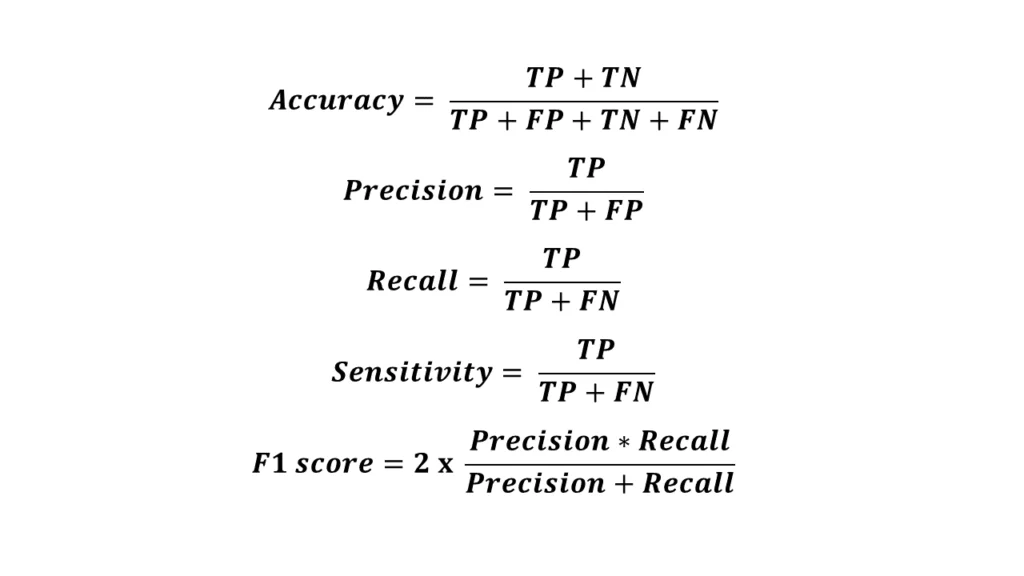

In [ ]:
# =====================================================
# 9. ANALISIS PREDIKSI DAN ERROR CASES (QUALITATIVE ANALYSIS)
# =====================================================
import pandas as pd

print("\n--- Menyusun DataFrame Analisis ---")

# 1. Gabungkan Hasil Prediksi ke DataFrame Test
# Gunakan .copy() untuk menghindari SettingWithCopyWarning
df_analysis = df_test.copy()

# Masukkan label hasil prediksi dari tahap evaluasi sebelumnya
# Pastikan variabel y_true_labels dan y_pred_labels dari Section 8 masih ada di memori
df_analysis['True Label'] = y_true_labels
df_analysis['Predicted Label'] = y_pred_labels

# Cek kebenaran prediksi
df_analysis['Is Correct'] = df_analysis['True Label'] == df_analysis['Predicted Label']

# 2. Tampilkan Sampel Prediksi (Random)
print("\n--- 20 Contoh Prediksi Acak (Test Set) ---")
# Menampilkan kolom tertentu saja agar rapi
cols_to_show = ['text', 'True Label', 'Predicted Label', 'Is Correct']
prediction_sample = df_analysis[cols_to_show].sample(20, random_state=42).reset_index(drop=True)

# Truncate (potong) teks yang terlalu panjang agar tabel tidak berantakan
prediction_sample['text'] = prediction_sample['text'].apply(lambda x: x[:80] + '...' if len(x) > 80 else x)
print(prediction_sample.to_markdown(index=False))

# 3. Analisis Error Cases (Salah Prediksi)
# -----------------------------------------------------
error_cases = df_analysis[df_analysis['Is Correct'] == False]
total_errors = len(error_cases)
print(f"\nTotal Kesalahan Prediksi: {total_errors} dari {len(df_analysis)} data test.")

if total_errors > 0:
    # Ambil sampel error
    error_sample_size = min(15, total_errors)
    error_sample = error_cases[cols_to_show].sample(error_sample_size, random_state=42).reset_index(drop=True)

    # Potong teks panjang untuk display
    error_sample['text'] = error_sample['text'].apply(lambda x: x[:100] + '...' if len(x) > 100 else x)

    print(f"\n--- {error_sample_size} Contoh Error Cases (Analisis Kualitatif) ---")
    print("Gunakan tabel ini untuk menganalisis di Bab Pembahasan: Kenapa model salah?")
    print(error_sample.to_markdown(index=False))

    # 4. [BONUS AKADEMIK] Analisis Kesalahan Fatal (Critical Errors)
    # Kesalahan Fatal = Label Asli NEGATIVE tapi diprediksi POSITIVE (Bahaya bagi bisnis)
    critical_errors = error_cases[
        (error_cases['True Label'] == 'negative') &
        (error_cases['Predicted Label'] == 'positive')
    ]

    if not critical_errors.empty:
        print(f"\n[WARNING] Ditemukan {len(critical_errors)} Kesalahan Fatal (Negative -> Positive):")
        critical_sample = critical_errors[['text', 'True Label', 'Predicted Label']].head(5)
        print(critical_sample.to_markdown(index=False))
    else:
        print("\n[INFO] Bagus! Tidak ditemukan kesalahan fatal (Negative -> Positive).")

else:
    print("\n[INFO] Model Sempurna! Tidak ada kesalahan prediksi pada Test Set.")

In [ ]:
# =====================================================
# 10. WORDCLOUD PER REGION
# =====================================================

regions = df['region'].unique()

print("\n--- Visualisasi Wordcloud per Region ---")
plt.figure(figsize=(15, 12))

for i, region in enumerate(regions):
    # Filter teks untuk region saat ini
    region_texts = df[df['region'] == region]['clean_text'].str.cat(sep=' ')

    # Buat WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        min_font_size=10
    ).generate(region_texts)

    # Plot
    plt.subplot(2, 2, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud: {region}', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# 1. Cek nama kolom yang tersedia saat ini
print("Kolom yang ada di df:", df.columns.tolist())

<div _ngcontent-ng-c3631751934="" inline-copy-host=""
    class="markdown markdown-main-panel stronger enable-updated-hr-color"
    id="model-response-message-contentr_1138b21484e0a860" aria-live="polite" aria-busy="false" dir="ltr"
    style="--animation-duration: 400ms; --fade-animation-function: linear;">
    <h2 data-path-to-node="0">Struktur Data Ulasan Wisata</h2>
    <p data-path-to-node="1">Data ulasan wisata ini terdiri dari beberapa kol
    <hr data-path-to-node="2">
    <h3 data-path-to-node="3">1. Metadata Lokasi &amp; Sumber (Identitas Data)</h3>
    <p data-path-to-node="4">Kolom ini menjelaskan "Siapa" dan "Di mana" ulasan tersebut berada.</p>
    <ul data-path-to-node="5">
        <li>
            <p data-path-to-node="5,0,0"><b><code>region</code></b></p>
            <ul data-path-to-node="5,0,1">
                <li>
                    <p data-path-to-node="5,0,1,0,0"><b>Maksud:</b> Wilayah geografis yang lebih luas yang
                        mengelompokkan destinasi wisata.</p>
                </li>
                <li>
                    <p data-path-to-node="5,0,1,1,0"><b>Contoh:</b> "Bali Utara", "Bali Selatan", "Gianyar".</p>
                </li>
                <li>
                    <p data-path-to-node="5,0,1,2,0"><b>Fungsi:</b> Untuk membandingkan sentimen antar-wilayah (misal:
                        Apakah Bali Utara lebih disukai daripada Bali Selatan?).</p>
                </li>
            </ul>
        </li>
        <li>
            <p data-path-to-node="5,1,0"><b><code>location_name</code></b></p>
            <ul data-path-to-node="5,1,1">
                <li>
                    <p data-path-to-node="5,1,1,0,0"><b>Maksud:</b> Nama spesifik dari objek wisata tempat ulasan
                        diberikan.</p>
                </li>
                <li>
                    <p data-path-to-node="5,1,1,1,0"><b>Contoh:</b> "Tanah Lot", "Pantai Kuta", "Monkey Forest Ubud".
                    </p>
                </li>
                <li>
                    <p data-path-to-node="5,1,1,2,0"><b>Fungsi:</b> Untuk analisis mendalam per destinasi (seperti
                        WordCloud per destinasi yang baru saja kita buat).</p>
                </li>
            </ul>
        </li>
        <li>
            <p data-path-to-node="5,2,0"><b><code>source</code></b></p>
            <ul data-path-to-node="5,2,1">
                <li>
                    <p data-path-to-node="5,2,1,0,0"><b>Maksud:</b> Asal platform tempat data ulasan ini diambil
                        (scraping).</p>
                </li>
                <li>
                    <p data-path-to-node="5,2,1,1,0"><b>Contoh:</b> "Google Maps", "TripAdvisor".</p>
                </li>
                <li>
                    <p data-path-to-node="5,2,1,2,0"><b>Fungsi:</b> Mengetahui validitas sumber data.</p>
                </li>
            </ul>
        </li>
    </ul>
    <hr data-path-to-node="6">
    <h3 data-path-to-node="7">2. Data Asli Pengguna (Input Mentah)</h3>
    <p data-path-to-node="8">Kolom ini berisi data murni yang diinput oleh turis/pengunjung.</p>
    <ul data-path-to-node="9">
        <li>
            <p data-path-to-node="9,0,0"><b><code>rating</code></b></p>
            <ul data-path-to-node="9,0,1">
                <li>
                    <p data-path-to-node="9,0,1,0,0"><b>Maksud:</b> Skor numerik (biasanya skala 1 sampai 5 bintang)
                        yang diberikan pengunjung.</p>
                </li>
                <li>
                    <p data-path-to-node="9,0,1,1,0"><b>Contoh:</b> <code>5</code> (Sangat Puas), <code>1</code> (Sangat
                        Kecewa).</p>
                </li>
                <li>
                    <p data-path-to-node="9,0,1,2,0"><b>Fungsi:</b> Sering digunakan sebagai acuan dasar
                        (<i>baseline</i>) untuk memverifikasi apakah analisis teks akurat.</p>
                </li>
            </ul>
        </li>
        <li>
            <p data-path-to-node="9,1,0"><b><code>review_text</code></b></p>
            <ul data-path-to-node="9,1,1">
                <li>
                    <p data-path-to-node="9,1,1,0,0"><b>Maksud:</b> Teks komentar/ulasan <b>asli (mentah)</b> yang
                        ditulis pengunjung, masih mengandung emoji, tanda baca berantakan, huruf besar-kecil tak
                        beraturan, dll.</p>
                </li>
                <li>
                    <p data-path-to-node="9,1,1,1,0"><b>Contoh:</b> "Tempatnya BAGUS BANGET!!! 😍 Tapi tiket mahal..."
                    </p>
                </li>
                <li>
                    <p data-path-to-node="9,1,1,2,0"><b>Fungsi:</b> Arsip data asli sebelum diubah-ubah.</p>
                </li>
            </ul>
        </li>
    </ul>
    <hr data-path-to-node="10">
    <h3 data-path-to-node="11">3. Hasil Preprocessing &amp; Analisis (Data Olahan)</h3>
    <p data-path-to-node="12">Kolom ini adalah hasil kerja kode Python yang sudah Anda jalankan (pembersihan data dan
        analisis AI).</p>
    <ul data-path-to-node="13">
        <li>
            <p data-path-to-node="13,0,0"><b><code>clean_text</code></b></p>
            <ul data-path-to-node="13,0,1">
                <li>
                    <p data-path-to-node="13,0,1,0,0"><b>Maksud:</b> Versi bersih dari <code>review_text</code>.
                        Biasanya sudah melalui tahap <i>case folding</i> (huruf kecil semua), penghapusan tanda baca,
                        penghapusan emoji, dan <i>stopword removal</i>.</p>
                </li>
                <li>
                    <p data-path-to-node="13,0,1,1,0"><b>Contoh:</b> "tempat bagus banget tapi tiket mahal"</p>
                </li>
                <li>
                    <p data-path-to-node="13,0,1,2,0"><b>Fungsi:</b> <b>Input utama</b> untuk model VADER, BERT, dan
                        pembuatan WordCloud.</p>
                </li>
            </ul>
        </li>
        <li>
            <p data-path-to-node="13,1,0"><b><code>label_rating</code></b></p>
            <ul data-path-to-node="13,1,1">
                <li>
                    <p data-path-to-node="13,1,1,0,0"><b>Maksud:</b> Kategori sentimen yang dibuat berdasarkan angka
                        <code>rating</code>. Ini adalah pelabelan manual/heuristik.</p>
                </li>
                <li>
                    <p data-path-to-node="13,1,1,1,0"><b>Logika (Biasanya):</b> Bintang 5 = Positif, Bintang 3 = Netral,
                        Bintang 1 = Negatif.</p>
                </li>
                <li>
                    <p data-path-to-node="13,1,1,2,0"><b>Fungsi:</b> Sering dianggap sebagai label kebenaran (<i>Ground
                            Truth</i>) versi kasar.</p>
                </li>
            </ul>
        </li>
        <li>
            <p data-path-to-node="13,2,0"><b><code>label_vader</code></b></p>
            <ul data-path-to-node="13,2,1">
                <li>
                    <p data-path-to-node="13,2,1,0,0"><b>Maksud:</b> Kategori sentimen (Positif/Negatif/Netral) hasil
                        prediksi algoritma <b>VADER</b> (<i>Valence Aware Dictionary and sEntiment Reasoner</i>). VADER
                        membaca kata-kata di <code>clean_text</code> dan menghitung skor emosinya.</p>
                </li>
                <li>
                    <p data-path-to-node="13,2,1,1,0"><b>Fungsi:</b> Label alternatif berbasis teks. Dalam proyek ini,
                        sepertinya Anda menggunakan kolom ini sebagai label target untuk pelatihan BERT.</p>
                </li>
            </ul>
        </li>
        <li>
            <p data-path-to-node="13,3,0"><b><code>ner_entities</code></b></p>
            <ul data-path-to-node="13,3,1">
                <li>
                    <p data-path-to-node="13,3,1,0,0"><b>Maksud:</b> Daftar entitas penting yang diekstraksi dari teks
                        menggunakan teknik <b>NER</b> (<i>Named Entity Recognition</i>).</p>
                </li>
                <li>
                    <p data-path-to-node="13,3,1,1,0"><b>Isi:</b> Bisa berupa nama Orang (PERSON), Lokasi lain
                        (GPE/LOC), atau Organisasi (ORG) yang disebut dalam ulasan.</p>
                </li>
                <li>
                    <p data-path-to-node="13,3,1,2,0"><b>Fungsi:</b> Untuk mengetahui "Siapa" atau "Apa" yang sering
                        disebut-sebut dalam ulasan selain tempat wisata itu sendiri.</p>
                </li>
            </ul>
        </li>
    </ul>
</div>

In [ ]:
df.head(5)

In [ ]:
# =====================================================
# 10.1. WORDCLOUD PER REGION & SENTIMENT
# =====================================================
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. Tentukan kolom sentimen utama (Pilih label_vader atau label_rating)
# Kita gunakan label_vader sebagai default karena ini hasil analisis teks
df['label'] = df['label_vader'].astype(str).str.lower()

# Cek apakah isinya sudah benar (positive/negative/neutral)
print("Distribusi Label Sentimen:")
print(df['label'].value_counts())

# 2. Definisikan Warna & Kategori
regions = df['region'].unique()
sentiment_categories = ['negative', 'neutral', 'positive']

colormap_dict = {
    'negative': 'Reds',
    'neutral': 'binary',
    'positive': 'Greens'
}

print("\n--- Visualisasi Wordcloud: Per Region & Per Sentimen ---")

for region in regions:
    # Filter data hanya untuk region ini
    df_region = df[df['region'] == region]

    # Lewati jika region tidak memiliki data
    if len(df_region) == 0:
        continue

    print(f"Generating WordCloud for region: {region}...")

    # Buat kanvas gambar (3 kolom untuk Neg, Neu, Pos)
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle(f'REGION: {str(region).upper()}', fontsize=24, weight='bold', y=1.05)

    for i, sentiment in enumerate(sentiment_categories):
        ax = axes[i]

        # Filter data berdasarkan sentimen
        subset = df_region[df_region['label'] == sentiment]

        # Gabungkan teks
        text_combined = subset['clean_text'].astype(str).str.cat(sep=' ')

        if len(text_combined.strip()) > 0:
            try:
                # Generate WordCloud
                wordcloud = WordCloud(
                    width=800,
                    height=400,
                    background_color='white',
                    colormap=colormap_dict[sentiment],
                    min_font_size=10,
                    random_state=42,
                    stopwords=None # Tambahkan set stopwords jika punya
                ).generate(text_combined)

                ax.imshow(wordcloud, interpolation='bilinear')
                ax.set_title(f'{sentiment.capitalize()} ({len(subset)})', fontsize=18, color='black')
            except ValueError:
                # Handle error jika teks terlalu sedikit/kosong
                ax.text(0.5, 0.5, "Data teks tidak valid", ha='center', va='center', fontsize=14)
                ax.set_title(f'{sentiment.capitalize()}', fontsize=18)
        else:
            # Jika tidak ada data sentimen tersebut di region ini
            ax.text(0.5, 0.5, "Tidak ada data", ha='center', va='center', fontsize=14)
            ax.set_title(f'{sentiment.capitalize()}', fontsize=18)

        ax.axis('off')

    plt.tight_layout()
    plt.show()

--- Menampilkan WordCloud untuk 8 Destinasi Terpopuler ---
[1/8] Generating WordCloud: Kebun Raya (1117 reviews)...


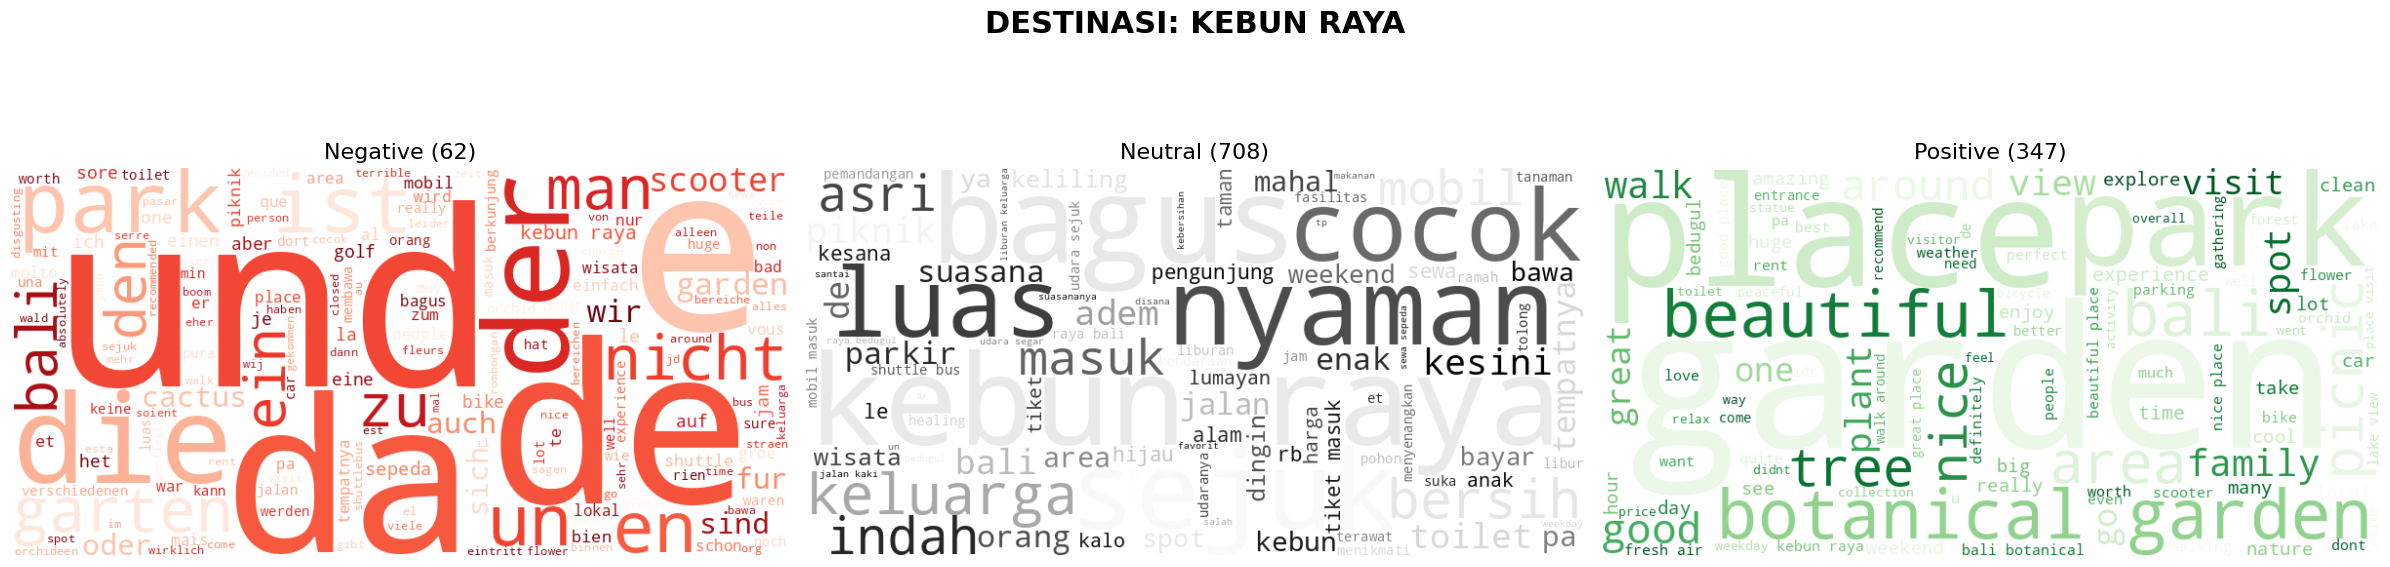

[2/8] Generating WordCloud: Dari DELUANG SARI Penangkaran Penyu Bali Tanjung Benoa (1087 reviews)...


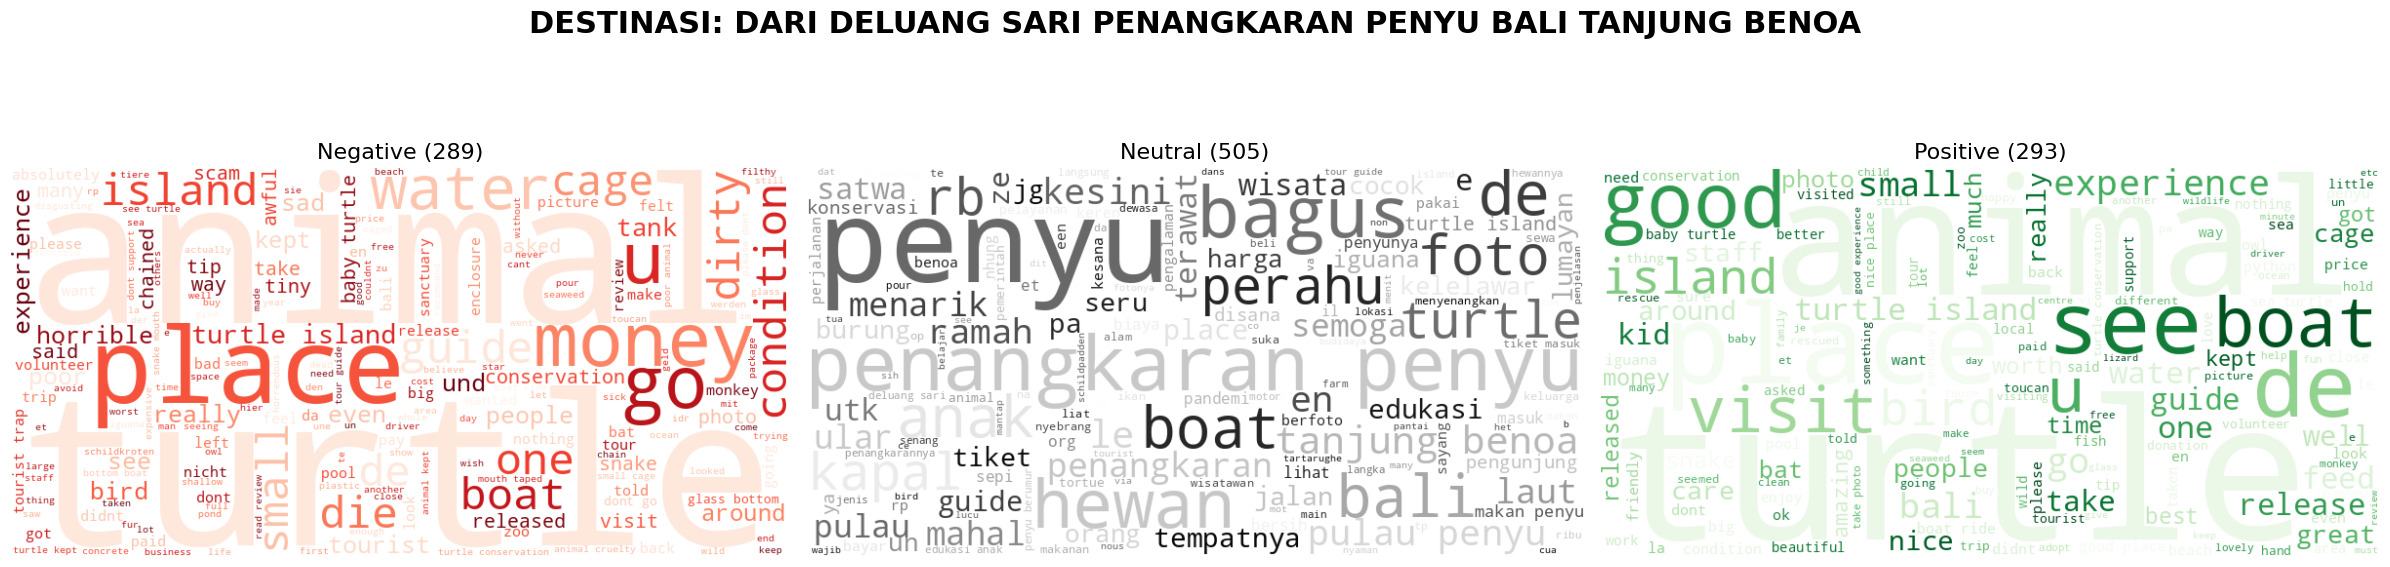

[3/8] Generating WordCloud: Lovina Beach (724 reviews)...


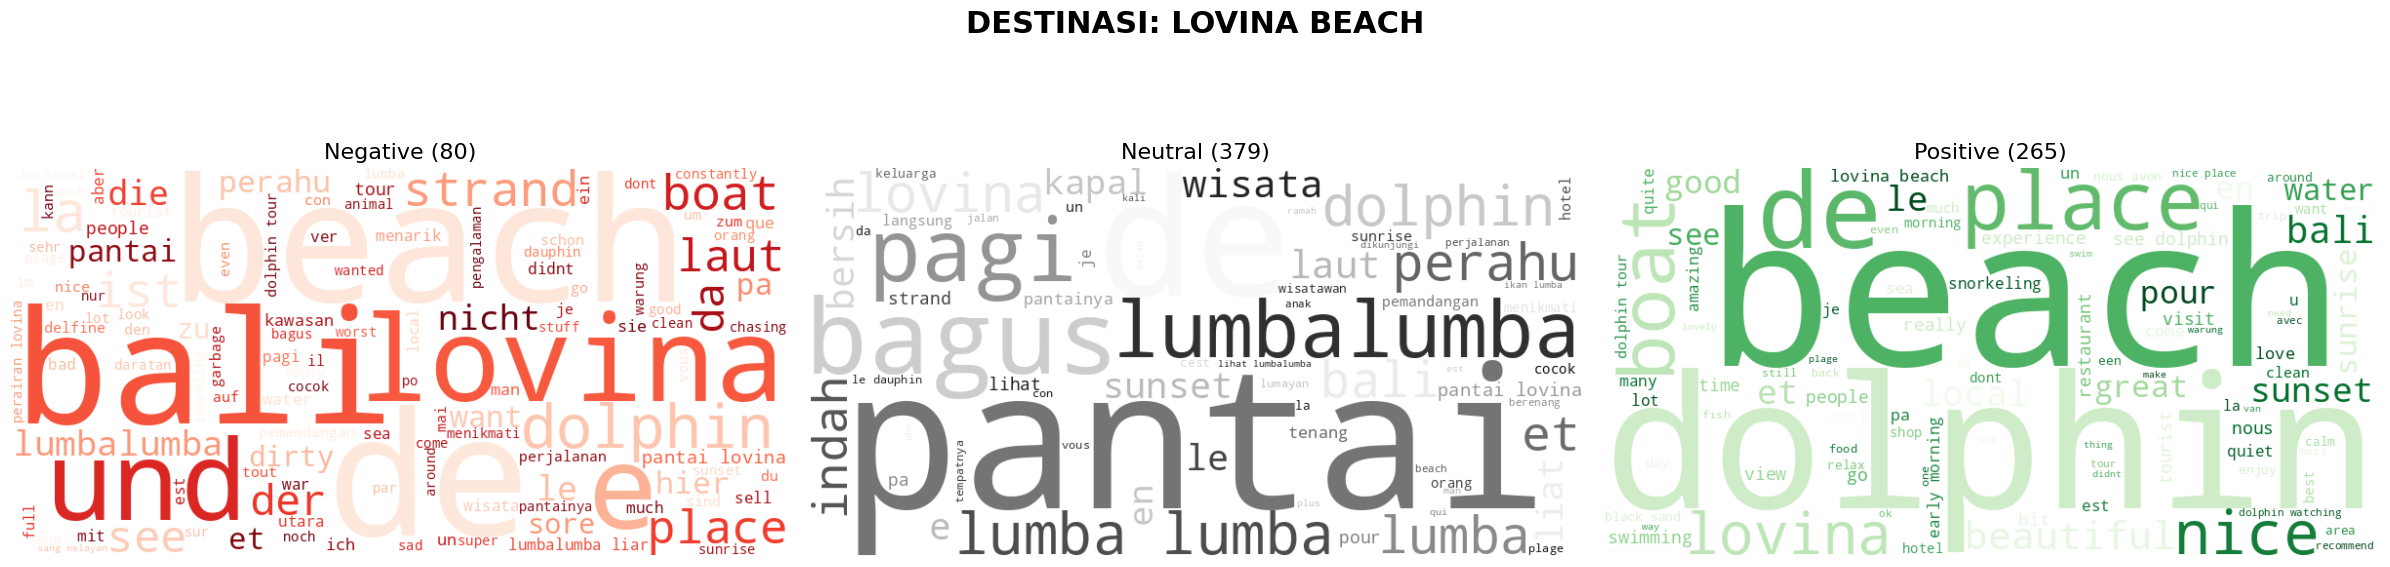

[4/8] Generating WordCloud: Tenganan Pegeringsingan Village (562 reviews)...


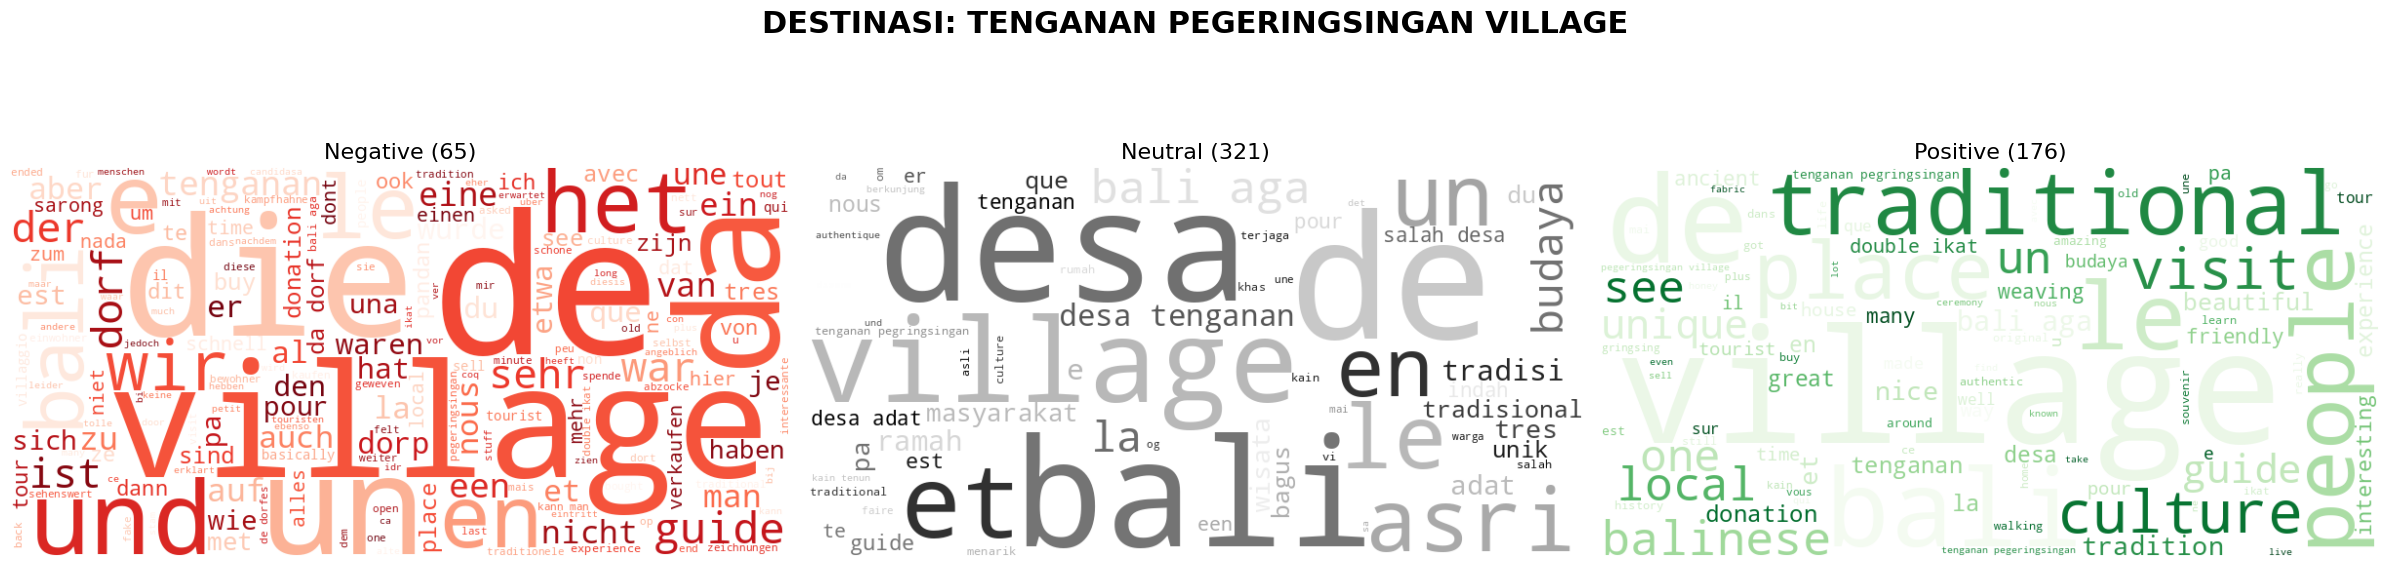

[5/8] Generating WordCloud: Taman Nasional (434 reviews)...


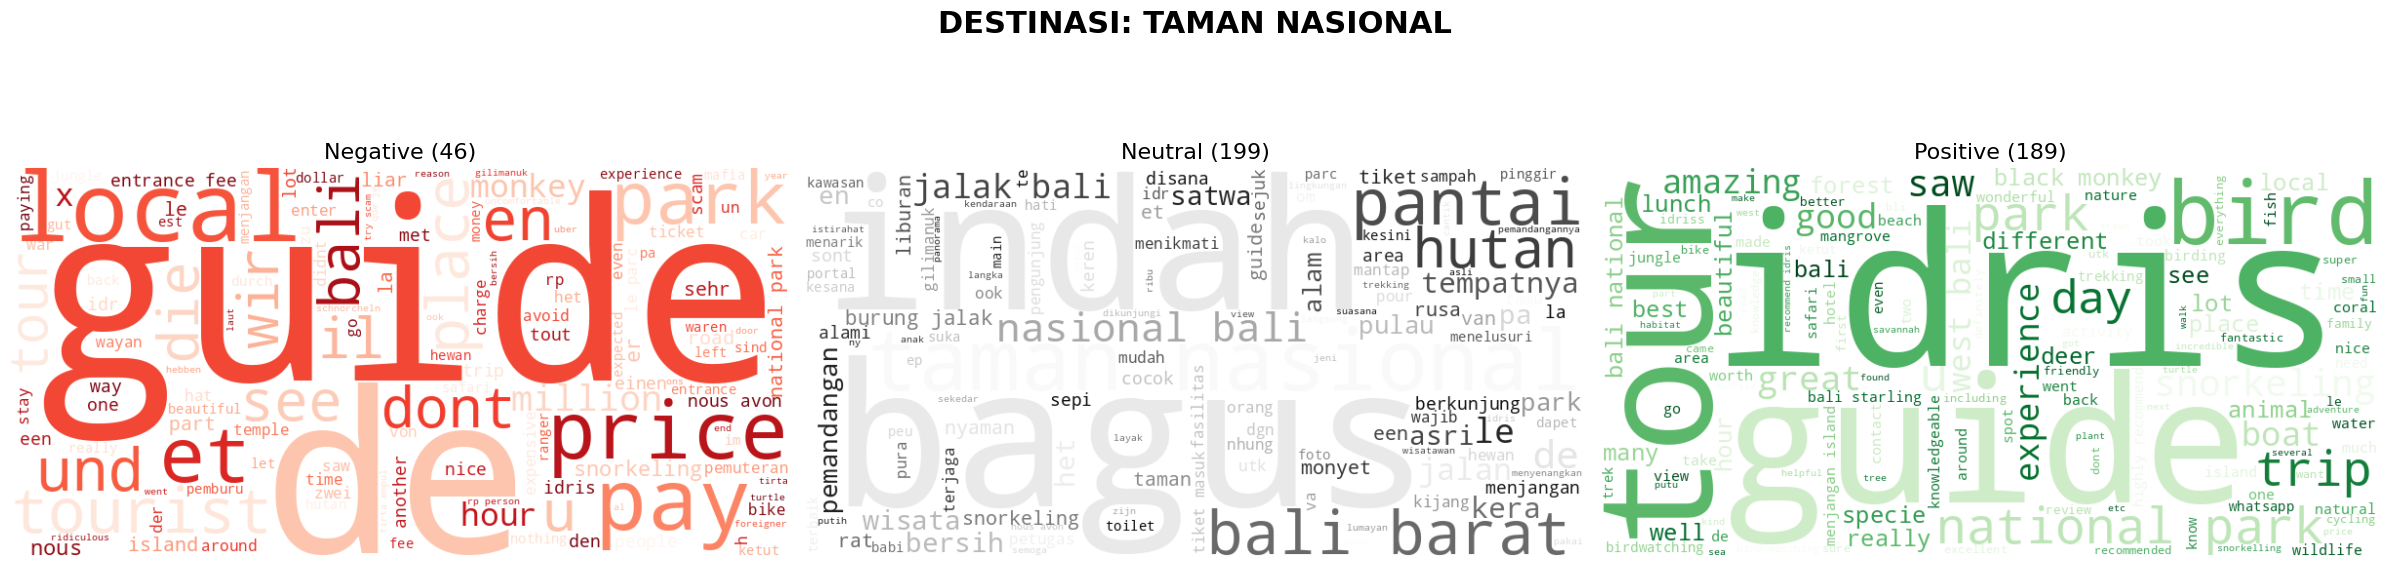

[6/8] Generating WordCloud: Subak Sembung (377 reviews)...


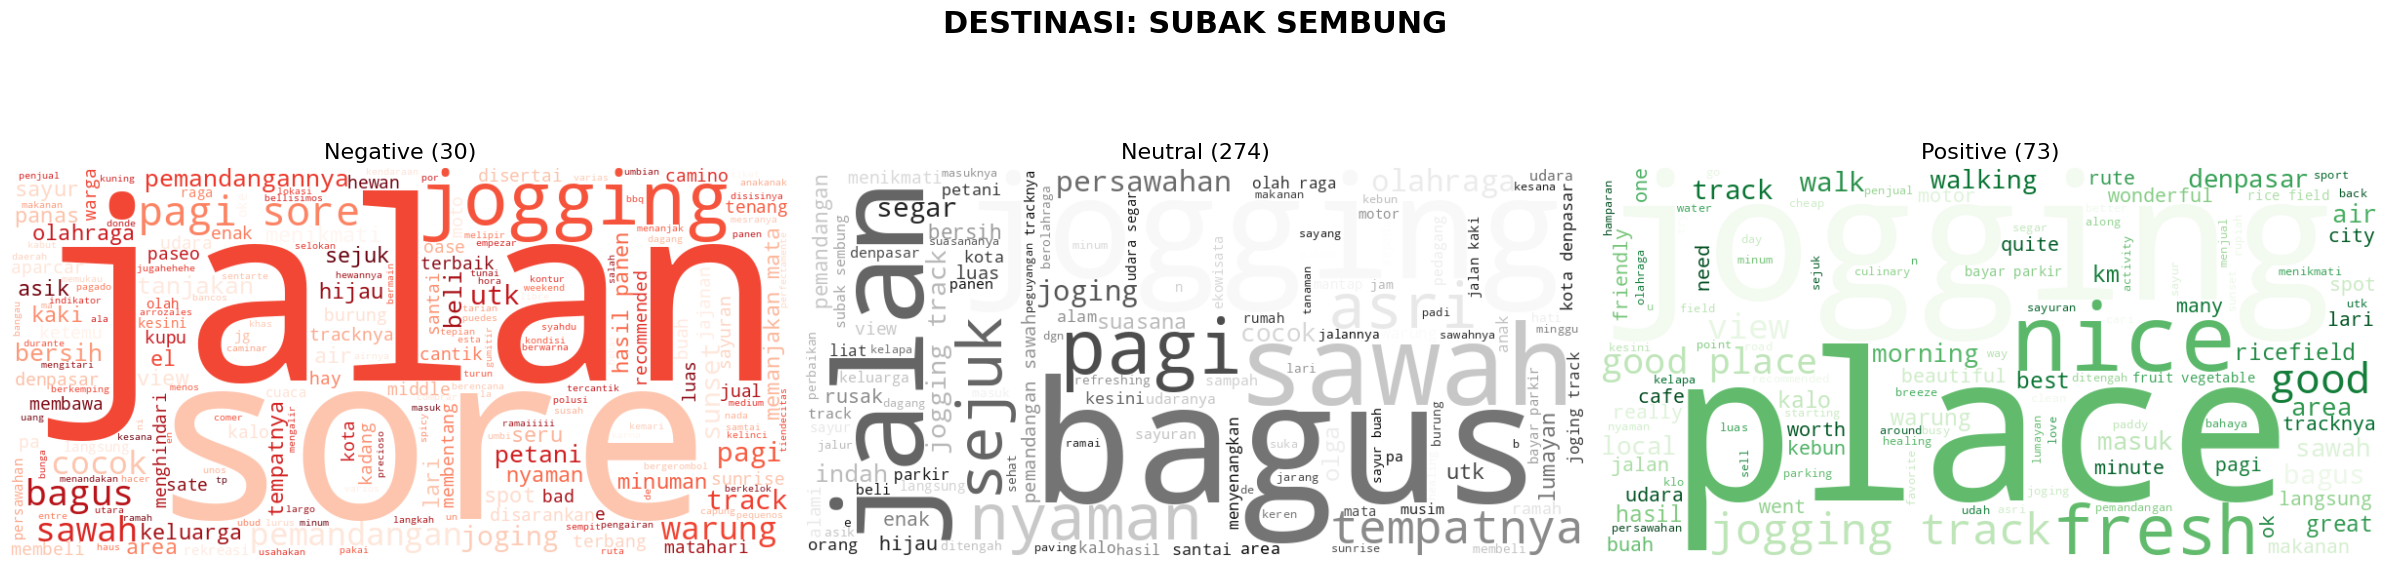

[7/8] Generating WordCloud: Nusa Lembongan (248 reviews)...


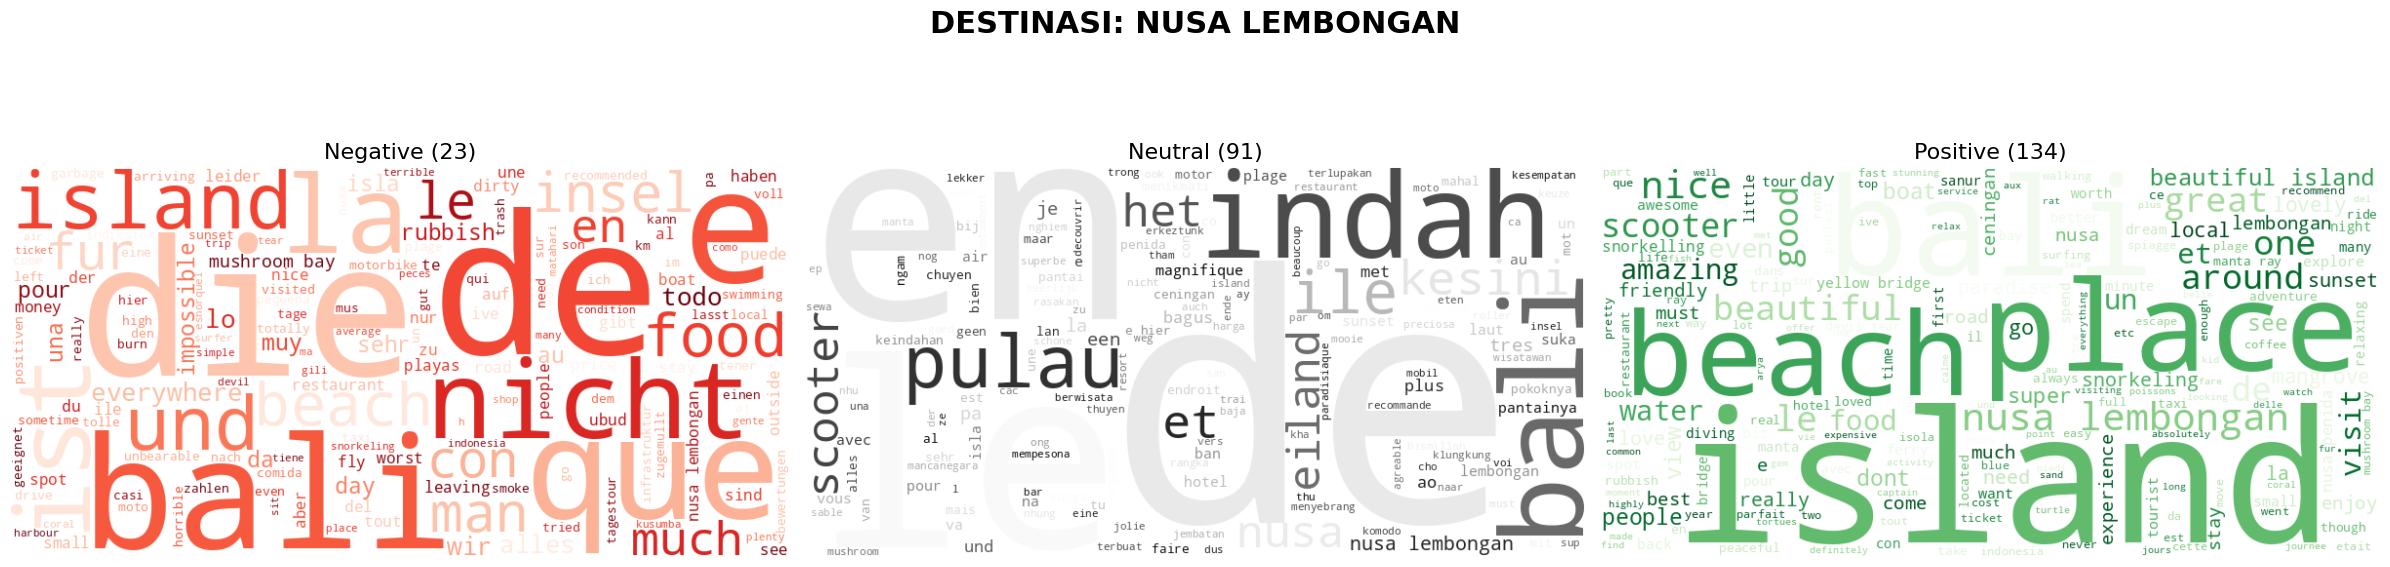

[8/8] Generating WordCloud: Menjangan Island (192 reviews)...


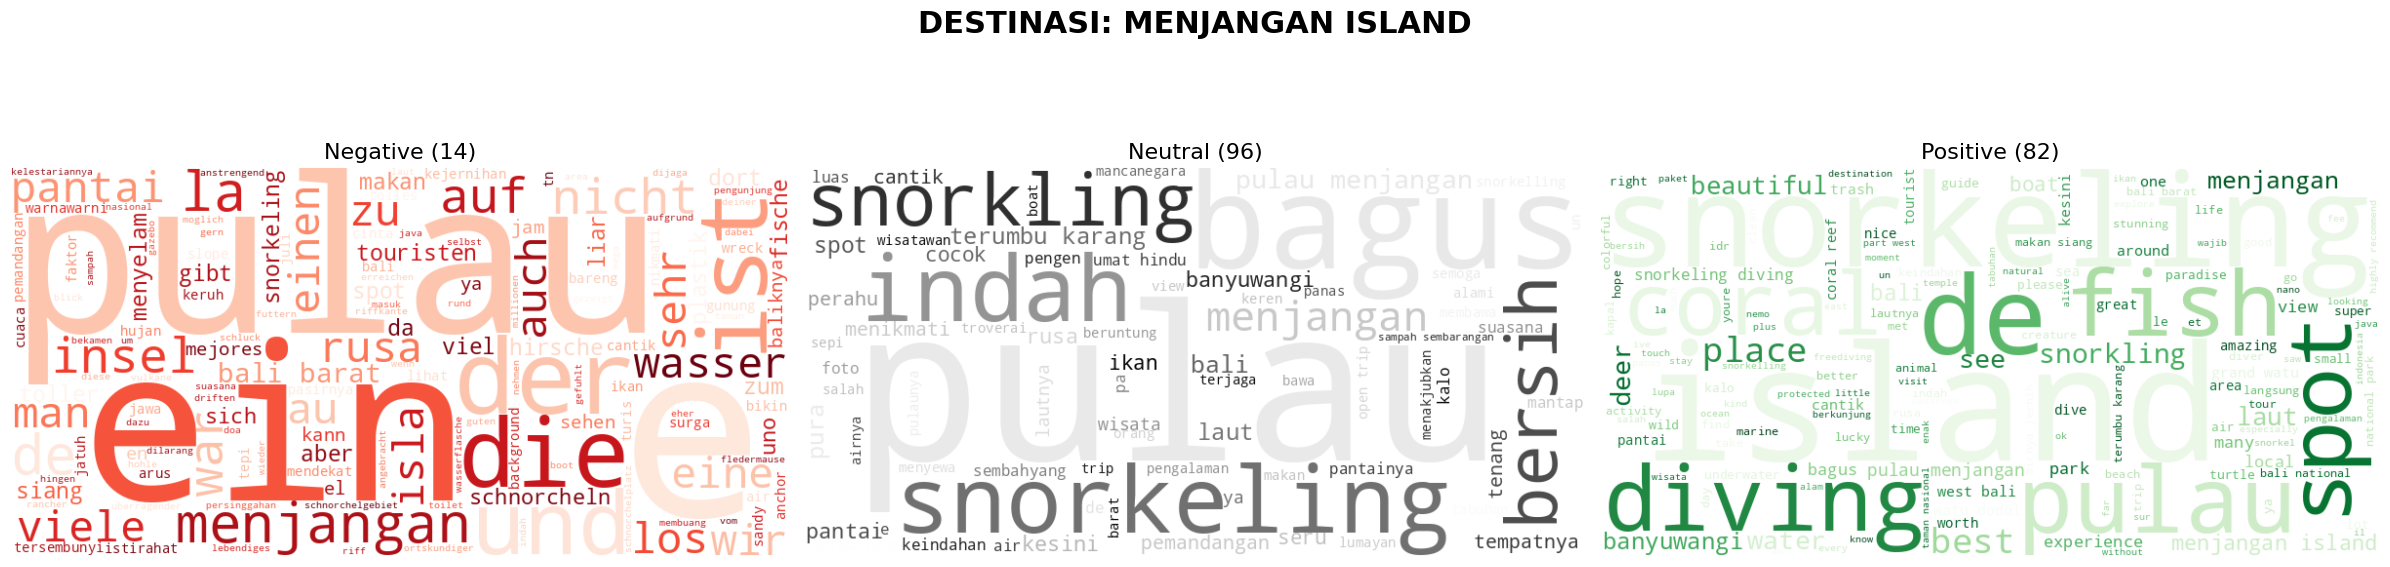

In [ ]:
# =====================================================
# 10.2. WORDCLOUD PER DESTINASI (LOCATION_NAME)
# =====================================================
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 1. Pastikan kolom label tersedia (Safety check)
if 'label' not in df.columns:
    if 'label_vader' in df.columns:
        df['label'] = df['label_vader'].astype(str).str.lower()
    else:
        print("Error: Kolom sentimen tidak ditemukan (label/label_vader).")

# 2. Urutkan destinasi berdasarkan jumlah review terbanyak
# Agar visualisasi yang muncul duluan adalah destinasi populer
top_destinations = df['location_name'].value_counts().index.tolist()

# Batasi jumlah destinasi jika terlalu banyak (Opsional, misal ambil 10 teratas)
# Hapus slicing [:10] di bawah jika ingin menampilkan SEMUA destinasi
target_destinations = top_destinations[:10]

print(f"--- Menampilkan WordCloud untuk {len(target_destinations)} Destinasi Terpopuler ---")

# Setup Warna
colormap_dict = {'negative': 'Reds', 'neutral': 'binary', 'positive': 'Greens'}
sentiment_categories = ['negative', 'neutral', 'positive']

for i, location in enumerate(target_destinations):
    # Filter data khusus destinasi ini
    df_loc = df[df['location_name'] == location]

    print(f"[{i+1}/{len(target_destinations)}] Generating WordCloud: {location} ({len(df_loc)} reviews)...")

    # Siapkan Figure
    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    fig.suptitle(f'DESTINASI: {str(location).upper()}', fontsize=22, weight='bold', y=1.05)

    # Loop per sentimen (Negatif, Netral, Positif)
    for j, sentiment in enumerate(sentiment_categories):
        ax = axes[j]

        # Ambil teks sesuai sentimen
        subset = df_loc[df_loc['label'] == sentiment]
        text_combined = subset['clean_text'].astype(str).str.cat(sep=' ')

        if len(text_combined.strip()) > 0:
            try:
                wordcloud = WordCloud(
                    width=800, height=400,
                    background_color='white',
                    colormap=colormap_dict[sentiment], # Warna khusus
                    min_font_size=10,
                    random_state=42
                ).generate(text_combined)

                ax.imshow(wordcloud, interpolation='bilinear')
                ax.set_title(f'{sentiment.capitalize()} ({len(subset)})', fontsize=16, color='black')
            except:
                ax.text(0.5, 0.5, "Error Generate", ha='center', va='center')
        else:
            # Jika tidak ada review untuk sentimen tersebut
            ax.text(0.5, 0.5, "Tidak ada data", ha='center', va='center', fontsize=12, color='gray')
            ax.set_title(f'{sentiment.capitalize()} (0)', fontsize=16, color='gray')

        ax.axis('off')

    plt.tight_layout()
    plt.show()


--- Analisis Bigram (Pasangan Kata) ---

**Top 20 Bigram Global:**
| bigram            |   count |
|:------------------|--------:|
| kebun raya        |     131 |
| turtle island     |      94 |
| botanical garden  |      78 |
| national park     |      72 |
| penangkaran penyu |      68 |
| nice place        |      66 |
| bali aga          |      60 |
| good place        |      60 |
| tiket masuk       |      50 |
| baby turtle       |      46 |
| tour guide        |      44 |
| nous avon         |      41 |
| lumba lumba       |      41 |
| west bali         |      40 |
| tourist trap      |      40 |
| de la             |      40 |
| bali barat        |      39 |
| sea turtle        |      38 |
| highly recommend  |      38 |
| jogging track     |      38 |

**Top 20 Bigram untuk Sentimen: positive**
| bigram            |   count |
|:------------------|--------:|
| kebun raya        |     102 |
| botanical garden  |      65 |
| nice place        |      64 |
| penangkaran penyu |   

/tmp/ipython-input-1149939179.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=top_20_global, palette="magma")


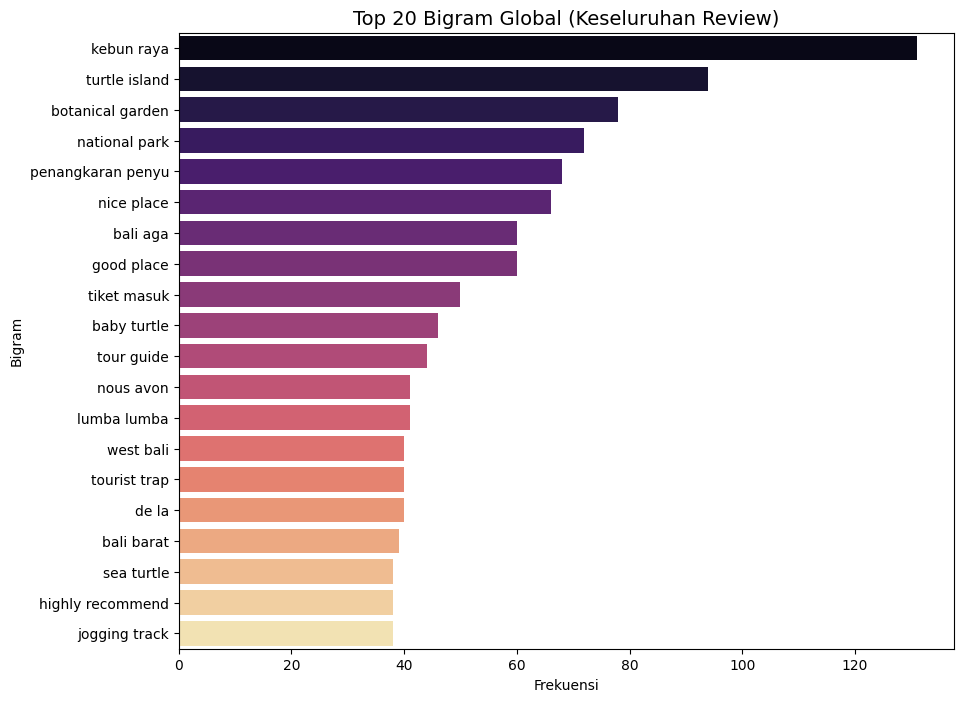


--- Wordcloud Bigram per Sentimen ---


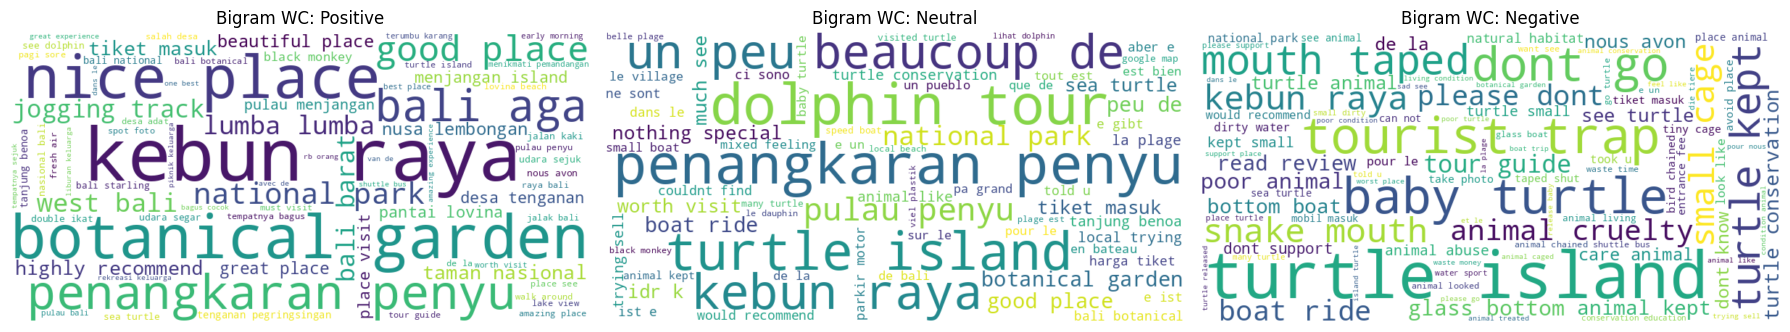

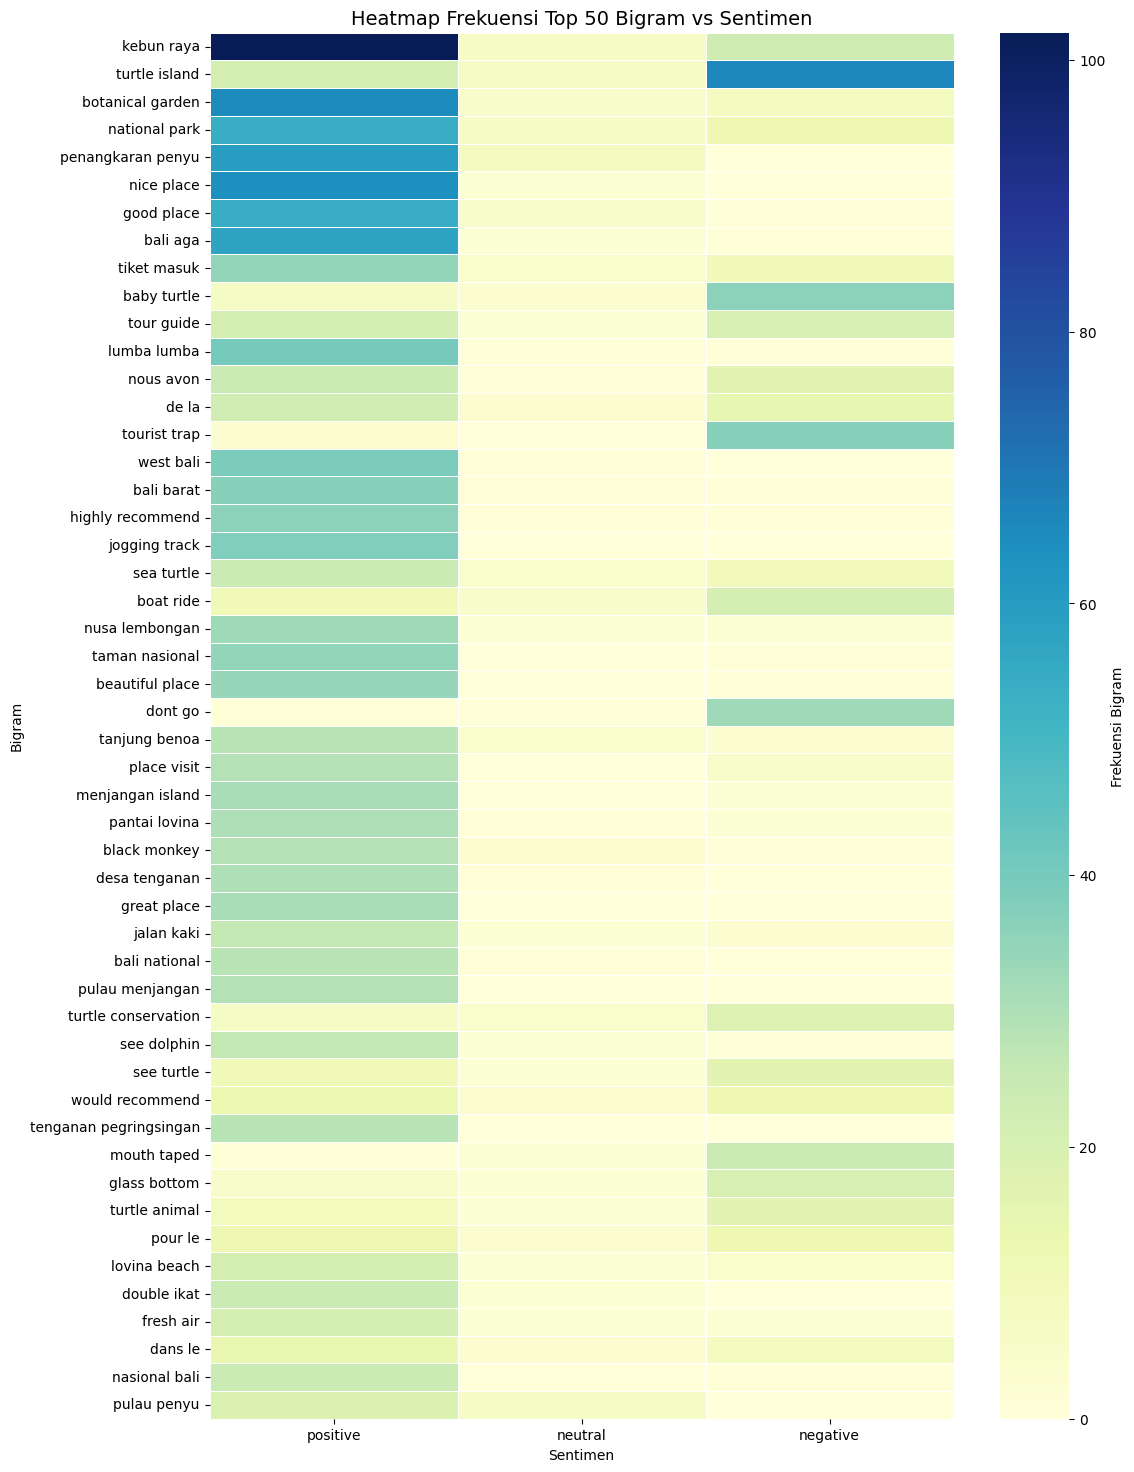

In [ ]:
# =====================================================
# 11. BIGRAM ANALYSIS (WAJIB ADA)
# =====================================================

print("\n--- Analisis Bigram (Pasangan Kata) ---")

# 11.1 & 11.2 Ekstraksi Bigram dan Perhitungan Global
# Menggunakan CountVectorizer untuk ekstraksi Bigram global
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words=None) # Stopwords sudah dihapus di preprocessing
bigram_matrix = vectorizer.fit_transform(df['clean_text'])
bigram_names = vectorizer.get_feature_names_out()
bigram_counts = np.sum(bigram_matrix.toarray(), axis=0)

# Buat DataFrame Bigram Global
global_bigram_df = pd.DataFrame({'bigram': bigram_names, 'count': bigram_counts})
global_bigram_df = global_bigram_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# Top 20 Global
top_20_global = global_bigram_df.head(20)
print("\n**Top 20 Bigram Global:**")
print(top_20_global.to_markdown(index=False))

# --- Ekstraksi Bigram per Sentimen ---
bigram_sentiment_data = []

for sentiment in ['positive', 'neutral', 'negative']:
    # Filter teks berdasarkan label sentimen
    sentiment_text = df[df['label_rating'] == sentiment]['clean_text'].str.cat(sep=' ')

    # Ekstraksi Bigram menggunakan NLTK (Metode 1)
    tokens = word_tokenize(sentiment_text)
    bigrams_nltk = list(nltk.ngrams(tokens, 2))
    bigram_counts_nltk = Counter(bigrams_nltk)

    # Ambil Top 20
    top_20_sentiment = bigram_counts_nltk.most_common(20)

    print(f"\n**Top 20 Bigram untuk Sentimen: {sentiment}**")
    top_20_df = pd.DataFrame(
        [(" ".join(bg), count) for bg, count in top_20_sentiment],
        columns=['bigram', 'count']
    )
    print(top_20_df.to_markdown(index=False))

    # Gabungkan semua bigram per sentimen untuk visualisasi heatmap
    for (bg_word1, bg_word2), count in bigram_counts_nltk.items():
        bigram_sentiment_data.append({
            'bigram': f"{bg_word1} {bg_word2}",
            'count': count,
            'sentiment': sentiment
        })

# 11.3 Buat dataframe bigram lengkap
bigram_sentiment_df = pd.DataFrame(bigram_sentiment_data)
# Ambil 50 bigram teratas secara global dari data sentimen untuk heatmap
top_50_heatmap_bigrams = bigram_sentiment_df.groupby('bigram')['count'].sum().nlargest(50).index.tolist()
bigram_sentiment_df_filtered = bigram_sentiment_df[bigram_sentiment_df['bigram'].isin(top_50_heatmap_bigrams)]

# 11.4 Visualisasi

# (a) Horizontal bar chart: Top 20 bigram global
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='bigram', data=top_20_global, palette="magma")
plt.title('Top 20 Bigram Global (Keseluruhan Review)', fontsize=14)
plt.xlabel('Frekuensi')
plt.ylabel('Bigram')
plt.show()

# (b) Wordcloud bigram per sentiment
print("\n--- Wordcloud Bigram per Sentimen ---")
plt.figure(figsize=(18, 5))

for i, sentiment in enumerate(['positive', 'neutral', 'negative']):
    # Filter data bigram untuk sentimen saat ini
    sentiment_data = bigram_sentiment_df[bigram_sentiment_df['sentiment'] == sentiment]

    # Buat dictionary frekuensi bigram
    bigram_freq = dict(zip(sentiment_data['bigram'], sentiment_data['count']))

    # Buat WordCloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        min_font_size=10
    ).generate_from_frequencies(bigram_freq)

    # Plot
    plt.subplot(1, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Bigram WC: {sentiment.capitalize()}', fontsize=12)

plt.tight_layout()
plt.show()


# (c) Heatmap bigram × sentiment (frekuensi)
# Pivot tabel untuk format Heatmap
heatmap_data = bigram_sentiment_df_filtered.pivot_table(
    index='bigram',
    columns='sentiment',
    values='count',
    fill_value=0 # Isi nilai yang hilang (bigram tidak muncul di kelas) dengan 0
)

# Urutkan berdasarkan total frekuensi untuk tampilan yang lebih baik
heatmap_data['Total'] = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.sort_values(by='Total', ascending=False).drop(columns=['Total'])

plt.figure(figsize=(12, 18)) # Ukuran yang lebih besar untuk 50 bigram
sns.heatmap(
    heatmap_data[['positive', 'neutral', 'negative']],
    annot=False, # Matriks terlalu besar, non-aktifkan anotasi
    fmt='d',
    cmap='YlGnBu',
    linewidths=.5,
    cbar_kws={'label': 'Frekuensi Bigram'}
)
plt.title('Heatmap Frekuensi Top 50 Bigram vs Sentimen', fontsize=14)
plt.ylabel('Bigram')
plt.xlabel('Sentimen')
plt.yticks(rotation=0) # Memperbaiki orientasi label bigram
plt.show()

<div _ngcontent-ng-c3631751934="" inline-copy-host=""
    class="markdown markdown-main-panel stronger enable-updated-hr-color"
    id="model-response-message-contentr_e357477c62ecf2f4" aria-live="polite" aria-busy="false" dir="ltr"
    style="--animation-duration: 400ms; --fade-animation-function: linear;">
    <hr data-path-to-node="1">
    <h1 data-path-to-node="2">📘 End-to-End Pipeline: Named Entity Recognition (NER) dengan BERT</h1>
    <p data-path-to-node="3">Catatan ini merangkum proses teknis <i>Fine-Tuning</i> BERT untuk tugas ekstraksi entitas
        (<i>Token Classification</i>).</p>
    <h2 data-path-to-node="4">1. Konsep Dasar: Token Classification</h2>
    <p data-path-to-node="5">Berbeda dengan Analisis Sentimen yang mengklasifikasikan satu kalimat utuh (Sentence
        Classification), NER bertugas mengklasifikasikan <b>setiap kata (token)</b> dalam kalimat.</p>
    <ul data-path-to-node="6">
        <li>
            <p data-path-to-node="6,0,0"><b>Input:</b> <code>["Saya", "liburan", "ke", "Bali"]</code></p>
        </li>
        <li>
            <p data-path-to-node="6,1,0"><b>Output:</b> <code>[O, O, O, B-LOC]</code></p>
        </li>
    </ul>
    <p data-path-to-node="7">Di mana:</p>
    <ul data-path-to-node="8">
        <li>
            <p data-path-to-node="8,0,0"><b>O</b> = Outside (Bukan entitas)</p>
        </li>
        <li>
            <p data-path-to-node="8,1,0"><b>B-LOC</b> = Beginning of Location (Awal nama lokasi)</p>
        </li>
    </ul>
    <hr data-path-to-node="9">
    <h2 data-path-to-node="10">2. Representasi Input (Embeddings)</h2>
    <p data-path-to-node="11">BERT tidak sekadar mengubah kata menjadi angka. Representasi input final (<span
            class="math-inline" data-math="E"><span class="katex"><span class="katex-html" aria-hidden="true"><span
                        class="base"><span class="strut" style="height: 0.6833em;"></span><span class="mord mathnormal"
                            style="margin-right: 0.0576em;">E</span></span></span></span></span>) adalah penjumlahan
        dari tiga komponen vektor:</p>
    <div data-path-to-node="12">
        <div class="math-block" data-math="E_{input} = E_{token} + E_{segment} + E_{position}"><span
                class="katex-display"><span class="katex"><span class="katex-html" aria-hidden="true"><span
                            class="base"><span class="strut"
                                style="height: 0.9694em; vertical-align: -0.2861em;"></span><span class="mord"><span
                                    class="mord mathnormal" style="margin-right: 0.0576em;">E</span><span
                                    class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span
                                                class="vlist" style="height: 0.3117em;"><span class=""
                                                    style="top: -2.55em; margin-left: -0.0576em; margin-right: 0.05em;"><span
                                                        class="pstrut" style="height: 2.7em;"></span><span
                                                        class="sizing reset-size6 size3 mtight"><span
                                                            class="mord mtight"><span
                                                                class="mord mathnormal mtight">in</span><span
                                                                class="mord mathnormal mtight">p</span><span
                                                                class="mord mathnormal mtight">u</span><span
                                                                class="mord mathnormal mtight">t</span></span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 0.2861em;"><span
                                                    class=""></span></span></span></span></span></span><span
                                class="mspace" style="margin-right: 0.2778em;"></span><span class="mrel">=</span><span
                                class="mspace" style="margin-right: 0.2778em;"></span></span><span class="base"><span
                                class="strut" style="height: 0.8333em; vertical-align: -0.15em;"></span><span
                                class="mord"><span class="mord mathnormal" style="margin-right: 0.0576em;">E</span><span
                                    class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span
                                                class="vlist" style="height: 0.3361em;"><span class=""
                                                    style="top: -2.55em; margin-left: -0.0576em; margin-right: 0.05em;"><span
                                                        class="pstrut" style="height: 2.7em;"></span><span
                                                        class="sizing reset-size6 size3 mtight"><span
                                                            class="mord mtight"><span
                                                                class="mord mathnormal mtight">t</span><span
                                                                class="mord mathnormal mtight">o</span><span
                                                                class="mord mathnormal mtight"
                                                                style="margin-right: 0.0315em;">k</span><span
                                                                class="mord mathnormal mtight">e</span><span
                                                                class="mord mathnormal mtight">n</span></span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 0.15em;"><span
                                                    class=""></span></span></span></span></span></span><span
                                class="mspace" style="margin-right: 0.2222em;"></span><span class="mbin">+</span><span
                                class="mspace" style="margin-right: 0.2222em;"></span></span><span class="base"><span
                                class="strut" style="height: 0.9694em; vertical-align: -0.2861em;"></span><span
                                class="mord"><span class="mord mathnormal" style="margin-right: 0.0576em;">E</span><span
                                    class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span
                                                class="vlist" style="height: 0.2806em;"><span class=""
                                                    style="top: -2.55em; margin-left: -0.0576em; margin-right: 0.05em;"><span
                                                        class="pstrut" style="height: 2.7em;"></span><span
                                                        class="sizing reset-size6 size3 mtight"><span
                                                            class="mord mtight"><span
                                                                class="mord mathnormal mtight">se</span><span
                                                                class="mord mathnormal mtight"
                                                                style="margin-right: 0.0359em;">g</span><span
                                                                class="mord mathnormal mtight">m</span><span
                                                                class="mord mathnormal mtight">e</span><span
                                                                class="mord mathnormal mtight">n</span><span
                                                                class="mord mathnormal mtight">t</span></span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 0.2861em;"><span
                                                    class=""></span></span></span></span></span></span><span
                                class="mspace" style="margin-right: 0.2222em;"></span><span class="mbin">+</span><span
                                class="mspace" style="margin-right: 0.2222em;"></span></span><span class="base"><span
                                class="strut" style="height: 0.9694em; vertical-align: -0.2861em;"></span><span
                                class="mord"><span class="mord mathnormal" style="margin-right: 0.0576em;">E</span><span
                                    class="msupsub"><span class="vlist-t vlist-t2"><span class="vlist-r"><span
                                                class="vlist" style="height: 0.3117em;"><span class=""
                                                    style="top: -2.55em; margin-left: -0.0576em; margin-right: 0.05em;"><span
                                                        class="pstrut" style="height: 2.7em;"></span><span
                                                        class="sizing reset-size6 size3 mtight"><span
                                                            class="mord mtight"><span
                                                                class="mord mathnormal mtight">p</span><span
                                                                class="mord mathnormal mtight">os</span><span
                                                                class="mord mathnormal mtight">i</span><span
                                                                class="mord mathnormal mtight">t</span><span
                                                                class="mord mathnormal mtight">i</span><span
                                                                class="mord mathnormal mtight">o</span><span
                                                                class="mord mathnormal mtight">n</span></span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 0.2861em;"><span
                                                    class=""></span></span></span></span></span></span></span></span></span></span>
        </div>
    </div>
    <ul data-path-to-node="13">
        <li>
            <p data-path-to-node="13,0,0"><b><span class="math-inline" data-math="E_{token}"><span class="katex"><span
                                class="katex-html" aria-hidden="true"><span class="base"><span class="strut"
                                        style="height: 0.8333em; vertical-align: -0.15em;"></span><span
                                        class="mord"><span class="mord mathnormal"
                                            style="margin-right: 0.0576em;">E</span><span class="msupsub"><span
                                                class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                                        style="height: 0.3361em;"><span class=""
                                                            style="top: -2.55em; margin-left: -0.0576em; margin-right: 0.05em;"><span
                                                                class="pstrut" style="height: 2.7em;"></span><span
                                                                class="sizing reset-size6 size3 mtight"><span
                                                                    class="mord mtight"><span
                                                                        class="mord mathnormal mtight">t</span><span
                                                                        class="mord mathnormal mtight">o</span><span
                                                                        class="mord mathnormal mtight"
                                                                        style="margin-right: 0.0315em;">k</span><span
                                                                        class="mord mathnormal mtight">e</span><span
                                                                        class="mord mathnormal mtight">n</span></span></span></span></span><span
                                                        class="vlist-s">​</span></span><span class="vlist-r"><span
                                                        class="vlist" style="height: 0.15em;"><span
                                                            class=""></span></span></span></span></span></span></span></span></span></span></b>:
                Embedding kata dari kamus WordPiece (~30.000 token).</p>
        </li>
        <li>
            <p data-path-to-node="13,1,0"><b><span class="math-inline" data-math="E_{segment}"><span class="katex"><span
                                class="katex-html" aria-hidden="true"><span class="base"><span class="strut"
                                        style="height: 0.9694em; vertical-align: -0.2861em;"></span><span
                                        class="mord"><span class="mord mathnormal"
                                            style="margin-right: 0.0576em;">E</span><span class="msupsub"><span
                                                class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                                        style="height: 0.2806em;"><span class=""
                                                            style="top: -2.55em; margin-left: -0.0576em; margin-right: 0.05em;"><span
                                                                class="pstrut" style="height: 2.7em;"></span><span
                                                                class="sizing reset-size6 size3 mtight"><span
                                                                    class="mord mtight"><span
                                                                        class="mord mathnormal mtight">se</span><span
                                                                        class="mord mathnormal mtight"
                                                                        style="margin-right: 0.0359em;">g</span><span
                                                                        class="mord mathnormal mtight">m</span><span
                                                                        class="mord mathnormal mtight">e</span><span
                                                                        class="mord mathnormal mtight">n</span><span
                                                                        class="mord mathnormal mtight">t</span></span></span></span></span><span
                                                        class="vlist-s">​</span></span><span class="vlist-r"><span
                                                        class="vlist" style="height: 0.2861em;"><span
                                                            class=""></span></span></span></span></span></span></span></span></span></span></b>:
                Membedakan kalimat A dan kalimat B (biasanya 0 untuk tugas kalimat tunggal).</p>
        </li>
        <li>
            <p data-path-to-node="13,2,0"><b><span class="math-inline" data-math="E_{position}"><span
                            class="katex"><span class="katex-html" aria-hidden="true"><span class="base"><span
                                        class="strut" style="height: 0.9694em; vertical-align: -0.2861em;"></span><span
                                        class="mord"><span class="mord mathnormal"
                                            style="margin-right: 0.0576em;">E</span><span class="msupsub"><span
                                                class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                                        style="height: 0.3117em;"><span class=""
                                                            style="top: -2.55em; margin-left: -0.0576em; margin-right: 0.05em;"><span
                                                                class="pstrut" style="height: 2.7em;"></span><span
                                                                class="sizing reset-size6 size3 mtight"><span
                                                                    class="mord mtight"><span
                                                                        class="mord mathnormal mtight">p</span><span
                                                                        class="mord mathnormal mtight">os</span><span
                                                                        class="mord mathnormal mtight">i</span><span
                                                                        class="mord mathnormal mtight">t</span><span
                                                                        class="mord mathnormal mtight">i</span><span
                                                                        class="mord mathnormal mtight">o</span><span
                                                                        class="mord mathnormal mtight">n</span></span></span></span></span><span
                                                        class="vlist-s">​</span></span><span class="vlist-r"><span
                                                        class="vlist" style="height: 0.2861em;"><span
                                                            class=""></span></span></span></span></span></span></span></span></span></span></b>:
                Informasi urutan kata, karena arsitektur Transformer memproses input secara paralel (bukan sekuensial
                seperti LSTM).</p>
        </li>
    </ul>
    <hr data-path-to-node="14">
    <h2 data-path-to-node="15">3. Preprocessing: WordPiece &amp; Alignment (Krusial)</h2>
    <p data-path-to-node="16">BERT menggunakan algoritma tokenisasi <b>WordPiece</b>. Kata yang tidak ada di kamus akan
        dipecah menjadi <i>sub-words</i>.</p>
    <p data-path-to-node="17"><b>Masalah:</b> Jumlah label asli (dari data latih) tidak sama dengan jumlah token hasil
        pecahan BERT.</p>
    <p data-path-to-node="18"><b>Contoh Kasus:</b></p>
    <ul data-path-to-node="19">
        <li>
            <p data-path-to-node="19,0,0">Kata Asli: <code>Yogyakarta</code> (1 kata, Label: <code>B-LOC</code>)</p>
        </li>
        <li>
            <p data-path-to-node="19,1,0">Token BERT: <code>['Yogya', '##karta']</code> (2 token)</p>
        </li>
    </ul>
    <p data-path-to-node="20"><b>Solusi (Label Alignment):</b>
        Kita menetapkan label hanya pada token pertama, dan memberikan <i>Ignored Index</i> pada token pecahan (suffix).
    </p>
    <div class="horizontal-scroll-wrapper">
        <div class="table-block-component"><response-element class=""
                ng-version="0.0.0-PLACEHOLDER"><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><table-block
                    _nghost-ng-c3323941553="" class="ng-star-inserted">
                    <div _ngcontent-ng-c3323941553="" class="table-block has-export-button">
                        <div _ngcontent-ng-c3323941553="" not-end-of-paragraph=""
                            class="table-content not-end-of-paragraph" jslog="275421;track:impression,attention"
                            data-hveid="0" decode-data-ved="1" data-ved="0CAAQ3ecQahgKEwi49IaZu7WRAxUAAAAAHQAAAAAQyg8">
                            <table data-path-to-node="21">
                                <thead>
                                    <tr>
                                        <td><span data-path-to-node="21,0,0,0">Token</span></td>
                                        <td><span data-path-to-node="21,0,1,0">Label Asli</span></td>
                                        <td><span data-path-to-node="21,0,2,0">Label Training</span></td>
                                        <td><span data-path-to-node="21,0,3,0">Keterangan</span></td>
                                    </tr>
                                </thead>
                                <tbody>
                                    <tr>
                                        <td><span data-path-to-node="21,1,0,0"><code>Yogya</code></span></td>
                                        <td><span data-path-to-node="21,1,1,0">B-LOC</span></td>
                                        <td><span data-path-to-node="21,1,2,0"><b>B-LOC</b></span></td>
                                        <td><span data-path-to-node="21,1,3,0">Token utama mengambil label asli.</span>
                                        </td>
                                    </tr>
                                    <tr>
                                        <td><span data-path-to-node="21,2,0,0"><code>##karta</code></span></td>
                                        <td><span data-path-to-node="21,2,1,0">-</span></td>
                                        <td><span data-path-to-node="21,2,2,0"><b>-100</b></span></td>
                                        <td><span data-path-to-node="21,2,3,0">Token pecahan diabaikan (masked).</span>
                                        </td>
                                    </tr>
                                </tbody>
                            </table>
                        </div>
                        <div _ngcontent-ng-c3323941553="" hide-from-message-actions=""
                            class="table-footer hide-from-message-actions ng-star-inserted"><button
                                _ngcontent-ng-c3323941553="" mat-button=""
                                class="mdc-button mat-mdc-button-base export-sheets-button-container mat-mdc-button mat-unthemed ng-star-inserted"
                                mat-ripple-loader-uninitialized="" mat-ripple-loader-class-name="mat-mdc-button-ripple"
                                jslog="184701;track:generic_click,impression;BardVeMetadataKey:[[&quot;r_e357477c62ecf2f4&quot;,&quot;c_a1c7bec01ae3eef8&quot;,null,null,null,null,null,null,1,null,null,null,0]]"><span
                                    class="mat-mdc-button-persistent-ripple mdc-button__ripple"></span><span
                                    class="mdc-button__label"><span _ngcontent-ng-c3323941553=""
                                        class="export-sheets-button"><span _ngcontent-ng-c3323941553=""
                                            class="export-sheets-icon"><mat-icon _ngcontent-ng-c3323941553="" role="img"
                                                fonticon="drive_spreadsheet"
                                                class="mat-icon notranslate google-symbols mat-ligature-font mat-icon-no-color"
                                                aria-hidden="true" data-mat-icon-type="font"
                                                data-mat-icon-name="drive_spreadsheet"></mat-icon></span><span
                                            _ngcontent-ng-c3323941553="">Ekspor ke Spreadsheet</span></span></span><span
                                    class="mat-focus-indicator"></span><span
                                    class="mat-mdc-button-touch-target"></span></button><!----><button
                                _ngcontent-ng-c3323941553="" mat-icon-button="" mattooltip="Salin tabel"
                                aria-label="Salin tabel" data-test-id="copy-table-button"
                                class="mdc-icon-button mat-mdc-icon-button mat-mdc-button-base mat-mdc-tooltip-trigger copy-button mat-unthemed ng-star-inserted"
                                mat-ripple-loader-uninitialized="" mat-ripple-loader-class-name="mat-mdc-button-ripple"
                                mat-ripple-loader-centered=""
                                jslog="276666;track:generic_click,impression;BardVeMetadataKey:[[&quot;r_e357477c62ecf2f4&quot;,&quot;c_a1c7bec01ae3eef8&quot;,null,null,null,null,null,null,1,null,null,null,0]]"><span
                                    class="mat-mdc-button-persistent-ripple mdc-icon-button__ripple"></span><mat-icon
                                    _ngcontent-ng-c3323941553="" role="img" fonticon="content_copy"
                                    class="mat-icon notranslate gds-icon-l google-symbols mat-ligature-font mat-icon-no-color"
                                    aria-hidden="true" data-mat-icon-type="font"
                                    data-mat-icon-name="content_copy"></mat-icon><span
                                    class="mat-focus-indicator"></span><span
                                    class="mat-mdc-button-touch-target"></span></button><!----><!----><!----></div>
                        <!---->
                    </div><!---->
                </table-block><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----><!----></response-element>
        </div>
    </div>
    <blockquote data-path-to-node="22">
        <p data-path-to-node="22,0"><b>Catatan:</b> Nilai <code>-100</code> adalah standar di PyTorch agar fungsi
            <i>Loss</i> mengabaikan token tersebut saat perhitungan gradien.</p>
    </blockquote>
    <hr data-path-to-node="23">
    <h2 data-path-to-node="24">4. Arsitektur Model &amp; Forward Pass</h2>
    <p data-path-to-node="25">Data melewati 12 layer <i>Encoder</i> BERT dan menghasilkan <i>Hidden States</i> (<span
            class="math-inline" data-math="H"><span class="katex"><span class="katex-html" aria-hidden="true"><span
                        class="base"><span class="strut" style="height: 0.6833em;"></span><span class="mord mathnormal"
                            style="margin-right: 0.0813em;">H</span></span></span></span></span>). Di atasnya, kita
        menempelkan satu lapisan linear (<i>Classifier Head</i>).</p>
    <p data-path-to-node="26">Rumus proyeksi ke label kelas:</p>
    <div data-path-to-node="27">
        <div class="math-block" data-math="Z = W \cdot H + b"><span class="katex-display"><span class="katex"><span
                        class="katex-html" aria-hidden="true"><span class="base"><span class="strut"
                                style="height: 0.6833em;"></span><span class="mord mathnormal"
                                style="margin-right: 0.0715em;">Z</span><span class="mspace"
                                style="margin-right: 0.2778em;"></span><span class="mrel">=</span><span class="mspace"
                                style="margin-right: 0.2778em;"></span></span><span class="base"><span class="strut"
                                style="height: 0.6833em;"></span><span class="mord mathnormal"
                                style="margin-right: 0.1389em;">W</span><span class="mspace"
                                style="margin-right: 0.2222em;"></span><span class="mbin">⋅</span><span class="mspace"
                                style="margin-right: 0.2222em;"></span></span><span class="base"><span class="strut"
                                style="height: 0.7667em; vertical-align: -0.0833em;"></span><span
                                class="mord mathnormal" style="margin-right: 0.0813em;">H</span><span class="mspace"
                                style="margin-right: 0.2222em;"></span><span class="mbin">+</span><span class="mspace"
                                style="margin-right: 0.2222em;"></span></span><span class="base"><span class="strut"
                                style="height: 0.6944em;"></span><span
                                class="mord mathnormal">b</span></span></span></span></span></div>
    </div>
    <p data-path-to-node="28">Dimana:</p>
    <ul data-path-to-node="29">
        <li>
            <p data-path-to-node="29,0,0"><span class="math-inline"
                    data-math="H \in \mathbb{R}^{Batch \times SeqLen \times 768}"><span class="katex"><span
                            class="katex-html" aria-hidden="true"><span class="base"><span class="strut"
                                    style="height: 0.7224em; vertical-align: -0.0391em;"></span><span
                                    class="mord mathnormal" style="margin-right: 0.0813em;">H</span><span class="mspace"
                                    style="margin-right: 0.2778em;"></span><span class="mrel">∈</span><span
                                    class="mspace" style="margin-right: 0.2778em;"></span></span><span
                                class="base"><span class="strut" style="height: 0.8491em;"></span><span
                                    class="mord"><span class="mord mathbb">R</span><span class="msupsub"><span
                                            class="vlist-t"><span class="vlist-r"><span class="vlist"
                                                    style="height: 0.8491em;"><span class=""
                                                        style="top: -3.063em; margin-right: 0.05em;"><span
                                                            class="pstrut" style="height: 2.7em;"></span><span
                                                            class="sizing reset-size6 size3 mtight"><span
                                                                class="mord mtight"><span class="mord mathnormal mtight"
                                                                    style="margin-right: 0.0502em;">B</span><span
                                                                    class="mord mathnormal mtight">a</span><span
                                                                    class="mord mathnormal mtight">t</span><span
                                                                    class="mord mathnormal mtight">c</span><span
                                                                    class="mord mathnormal mtight">h</span><span
                                                                    class="mbin mtight">×</span><span
                                                                    class="mord mathnormal mtight"
                                                                    style="margin-right: 0.0576em;">S</span><span
                                                                    class="mord mathnormal mtight">e</span><span
                                                                    class="mord mathnormal mtight"
                                                                    style="margin-right: 0.0359em;">q</span><span
                                                                    class="mord mathnormal mtight">L</span><span
                                                                    class="mord mathnormal mtight">e</span><span
                                                                    class="mord mathnormal mtight">n</span><span
                                                                    class="mbin mtight">×</span><span
                                                                    class="mord mtight">768</span></span></span></span></span></span></span></span></span></span></span></span></span>
                (Output BERT)</p>
        </li>
        <li>
            <p data-path-to-node="29,1,0"><span class="math-inline"
                    data-math="W \in \mathbb{R}^{768 \times NumLabels}"><span class="katex"><span class="katex-html"
                            aria-hidden="true"><span class="base"><span class="strut"
                                    style="height: 0.7224em; vertical-align: -0.0391em;"></span><span
                                    class="mord mathnormal" style="margin-right: 0.1389em;">W</span><span class="mspace"
                                    style="margin-right: 0.2778em;"></span><span class="mrel">∈</span><span
                                    class="mspace" style="margin-right: 0.2778em;"></span></span><span
                                class="base"><span class="strut" style="height: 0.8491em;"></span><span
                                    class="mord"><span class="mord mathbb">R</span><span class="msupsub"><span
                                            class="vlist-t"><span class="vlist-r"><span class="vlist"
                                                    style="height: 0.8491em;"><span class=""
                                                        style="top: -3.063em; margin-right: 0.05em;"><span
                                                            class="pstrut" style="height: 2.7em;"></span><span
                                                            class="sizing reset-size6 size3 mtight"><span
                                                                class="mord mtight"><span
                                                                    class="mord mtight">768</span><span
                                                                    class="mbin mtight">×</span><span
                                                                    class="mord mathnormal mtight"
                                                                    style="margin-right: 0.109em;">N</span><span
                                                                    class="mord mathnormal mtight">u</span><span
                                                                    class="mord mathnormal mtight">m</span><span
                                                                    class="mord mathnormal mtight">L</span><span
                                                                    class="mord mathnormal mtight">ab</span><span
                                                                    class="mord mathnormal mtight">e</span><span
                                                                    class="mord mathnormal mtight"
                                                                    style="margin-right: 0.0197em;">l</span><span
                                                                    class="mord mathnormal mtight">s</span></span></span></span></span></span></span></span></span></span></span></span></span>
                (Bobot Classifier)</p>
        </li>
        <li>
            <p data-path-to-node="29,2,0"><span class="math-inline" data-math="Z"><span class="katex"><span
                            class="katex-html" aria-hidden="true"><span class="base"><span class="strut"
                                    style="height: 0.6833em;"></span><span class="mord mathnormal"
                                    style="margin-right: 0.0715em;">Z</span></span></span></span></span> adalah
                <i>logits</i> (skor mentah sebelum probabilitas).</p>
        </li>
    </ul>
    <hr data-path-to-node="30">
    <h2 data-path-to-node="31">5. Fungsi Loss (Optimasi)</h2>
    <p data-path-to-node="32">Untuk melatih model, kita menghitung probabilitas menggunakan <b>Softmax</b>:</p>
    <div data-path-to-node="33">
        <div class="math-block" data-math="p_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}"><span
                class="katex-display"><span class="katex"><span class="katex-html" aria-hidden="true"><span
                            class="base"><span class="strut"
                                style="height: 0.625em; vertical-align: -0.1944em;"></span><span class="mord"><span
                                    class="mord mathnormal">p</span><span class="msupsub"><span
                                        class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                                style="height: 0.3117em;"><span class=""
                                                    style="top: -2.55em; margin-left: 0em; margin-right: 0.05em;"><span
                                                        class="pstrut" style="height: 2.7em;"></span><span
                                                        class="sizing reset-size6 size3 mtight"><span
                                                            class="mord mathnormal mtight">i</span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 0.15em;"><span
                                                    class=""></span></span></span></span></span></span><span
                                class="mspace" style="margin-right: 0.2778em;"></span><span class="mrel">=</span><span
                                class="mspace" style="margin-right: 0.2778em;"></span></span><span class="base"><span
                                class="strut" style="height: 2.6484em; vertical-align: -1.307em;"></span><span
                                class="mord"><span class="mopen nulldelimiter"></span><span class="mfrac"><span
                                        class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                                style="height: 1.3414em;"><span class="" style="top: -2.1288em;"><span
                                                        class="pstrut" style="height: 3em;"></span><span
                                                        class="mord"><span class="mop"><span
                                                                class="mop op-symbol small-op"
                                                                style="position: relative; top: 0em;">∑</span><span
                                                                class="msupsub"><span class="vlist-t vlist-t2"><span
                                                                        class="vlist-r"><span class="vlist"
                                                                            style="height: 0.9812em;"><span class=""
                                                                                style="top: -2.4003em; margin-left: 0em; margin-right: 0.05em;"><span
                                                                                    class="pstrut"
                                                                                    style="height: 2.7em;"></span><span
                                                                                    class="sizing reset-size6 size3 mtight"><span
                                                                                        class="mord mtight"><span
                                                                                            class="mord mathnormal mtight"
                                                                                            style="margin-right: 0.0572em;">j</span><span
                                                                                            class="mrel mtight">=</span><span
                                                                                            class="mord mtight">1</span></span></span></span><span
                                                                                class=""
                                                                                style="top: -3.2029em; margin-right: 0.05em;"><span
                                                                                    class="pstrut"
                                                                                    style="height: 2.7em;"></span><span
                                                                                    class="sizing reset-size6 size3 mtight"><span
                                                                                        class="mord mtight"><span
                                                                                            class="mord mathnormal mtight"
                                                                                            style="margin-right: 0.0715em;">K</span></span></span></span></span><span
                                                                            class="vlist-s">​</span></span><span
                                                                        class="vlist-r"><span class="vlist"
                                                                            style="height: 0.4358em;"><span
                                                                                class=""></span></span></span></span></span></span><span
                                                            class="mspace" style="margin-right: 0.1667em;"></span><span
                                                            class="mord"><span class="mord mathnormal">e</span><span
                                                                class="msupsub"><span class="vlist-t"><span
                                                                        class="vlist-r"><span class="vlist"
                                                                            style="height: 0.6065em;"><span class=""
                                                                                style="top: -3.0051em; margin-right: 0.05em;"><span
                                                                                    class="pstrut"
                                                                                    style="height: 2.7em;"></span><span
                                                                                    class="sizing reset-size6 size3 mtight"><span
                                                                                        class="mord mtight"><span
                                                                                            class="mord mtight"><span
                                                                                                class="mord mathnormal mtight"
                                                                                                style="margin-right: 0.044em;">z</span><span
                                                                                                class="msupsub"><span
                                                                                                    class="vlist-t vlist-t2"><span
                                                                                                        class="vlist-r"><span
                                                                                                            class="vlist"
                                                                                                            style="height: 0.3281em;"><span
                                                                                                                class=""
                                                                                                                style="top: -2.357em; margin-left: -0.044em; margin-right: 0.0714em;"><span
                                                                                                                    class="pstrut"
                                                                                                                    style="height: 2.5em;"></span><span
                                                                                                                    class="sizing reset-size3 size1 mtight"><span
                                                                                                                        class="mord mathnormal mtight"
                                                                                                                        style="margin-right: 0.0572em;">j</span></span></span></span><span
                                                                                                            class="vlist-s">​</span></span><span
                                                                                                        class="vlist-r"><span
                                                                                                            class="vlist"
                                                                                                            style="height: 0.2819em;"><span
                                                                                                                class=""></span></span></span></span></span></span></span></span></span></span></span></span></span></span></span></span><span
                                                    class="" style="top: -3.23em;"><span class="pstrut"
                                                        style="height: 3em;"></span><span class="frac-line"
                                                        style="border-bottom-width: 0.04em;"></span></span><span
                                                    class="" style="top: -3.677em;"><span class="pstrut"
                                                        style="height: 3em;"></span><span class="mord"><span
                                                            class="mord"><span class="mord mathnormal">e</span><span
                                                                class="msupsub"><span class="vlist-t"><span
                                                                        class="vlist-r"><span class="vlist"
                                                                            style="height: 0.6644em;"><span class=""
                                                                                style="top: -3.063em; margin-right: 0.05em;"><span
                                                                                    class="pstrut"
                                                                                    style="height: 2.7em;"></span><span
                                                                                    class="sizing reset-size6 size3 mtight"><span
                                                                                        class="mord mtight"><span
                                                                                            class="mord mtight"><span
                                                                                                class="mord mathnormal mtight"
                                                                                                style="margin-right: 0.044em;">z</span><span
                                                                                                class="msupsub"><span
                                                                                                    class="vlist-t vlist-t2"><span
                                                                                                        class="vlist-r"><span
                                                                                                            class="vlist"
                                                                                                            style="height: 0.3281em;"><span
                                                                                                                class=""
                                                                                                                style="top: -2.357em; margin-left: -0.044em; margin-right: 0.0714em;"><span
                                                                                                                    class="pstrut"
                                                                                                                    style="height: 2.5em;"></span><span
                                                                                                                    class="sizing reset-size3 size1 mtight"><span
                                                                                                                        class="mord mathnormal mtight">i</span></span></span></span><span
                                                                                                            class="vlist-s">​</span></span><span
                                                                                                        class="vlist-r"><span
                                                                                                            class="vlist"
                                                                                                            style="height: 0.143em;"><span
                                                                                                                class=""></span></span></span></span></span></span></span></span></span></span></span></span></span></span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 1.307em;"><span
                                                    class=""></span></span></span></span></span><span
                                    class="mclose nulldelimiter"></span></span></span></span></span></span></div>
    </div>
    <p data-path-to-node="34">Kemudian menghitung error menggunakan <b>Cross-Entropy Loss</b>:</p>
    <div data-path-to-node="35">
        <div class="math-block" data-math="L = - \frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{K} y_{i,c} \log(p_{i,c})"><span
                class="katex-display"><span class="katex"><span class="katex-html" aria-hidden="true"><span
                            class="base"><span class="strut" style="height: 0.6833em;"></span><span
                                class="mord mathnormal">L</span><span class="mspace"
                                style="margin-right: 0.2778em;"></span><span class="mrel">=</span><span class="mspace"
                                style="margin-right: 0.2778em;"></span></span><span class="base"><span class="strut"
                                style="height: 3.106em; vertical-align: -1.2777em;"></span><span
                                class="mord">−</span><span class="mord"><span class="mopen nulldelimiter"></span><span
                                    class="mfrac"><span class="vlist-t vlist-t2"><span class="vlist-r"><span
                                                class="vlist" style="height: 1.3214em;"><span class=""
                                                    style="top: -2.314em;"><span class="pstrut"
                                                        style="height: 3em;"></span><span class="mord"><span
                                                            class="mord mathnormal"
                                                            style="margin-right: 0.109em;">N</span></span></span><span
                                                    class="" style="top: -3.23em;"><span class="pstrut"
                                                        style="height: 3em;"></span><span class="frac-line"
                                                        style="border-bottom-width: 0.04em;"></span></span><span
                                                    class="" style="top: -3.677em;"><span class="pstrut"
                                                        style="height: 3em;"></span><span class="mord"><span
                                                            class="mord">1</span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 0.686em;"><span
                                                    class=""></span></span></span></span></span><span
                                    class="mclose nulldelimiter"></span></span><span class="mspace"
                                style="margin-right: 0.1667em;"></span><span class="mop op-limits"><span
                                    class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                            style="height: 1.8283em;"><span class=""
                                                style="top: -1.8723em; margin-left: 0em;"><span class="pstrut"
                                                    style="height: 3.05em;"></span><span
                                                    class="sizing reset-size6 size3 mtight"><span
                                                        class="mord mtight"><span
                                                            class="mord mathnormal mtight">i</span><span
                                                            class="mrel mtight">=</span><span
                                                            class="mord mtight">1</span></span></span></span><span
                                                class="" style="top: -3.05em;"><span class="pstrut"
                                                    style="height: 3.05em;"></span><span class=""><span
                                                        class="mop op-symbol large-op">∑</span></span></span><span
                                                class="" style="top: -4.3em; margin-left: 0em;"><span class="pstrut"
                                                    style="height: 3.05em;"></span><span
                                                    class="sizing reset-size6 size3 mtight"><span
                                                        class="mord mtight"><span class="mord mathnormal mtight"
                                                            style="margin-right: 0.109em;">N</span></span></span></span></span><span
                                            class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                            style="height: 1.2777em;"><span
                                                class=""></span></span></span></span></span><span class="mspace"
                                style="margin-right: 0.1667em;"></span><span class="mop op-limits"><span
                                    class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                            style="height: 1.8283em;"><span class=""
                                                style="top: -1.8829em; margin-left: 0em;"><span class="pstrut"
                                                    style="height: 3.05em;"></span><span
                                                    class="sizing reset-size6 size3 mtight"><span
                                                        class="mord mtight"><span
                                                            class="mord mathnormal mtight">c</span><span
                                                            class="mrel mtight">=</span><span
                                                            class="mord mtight">1</span></span></span></span><span
                                                class="" style="top: -3.05em;"><span class="pstrut"
                                                    style="height: 3.05em;"></span><span class=""><span
                                                        class="mop op-symbol large-op">∑</span></span></span><span
                                                class="" style="top: -4.3em; margin-left: 0em;"><span class="pstrut"
                                                    style="height: 3.05em;"></span><span
                                                    class="sizing reset-size6 size3 mtight"><span
                                                        class="mord mtight"><span class="mord mathnormal mtight"
                                                            style="margin-right: 0.0715em;">K</span></span></span></span></span><span
                                            class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                            style="height: 1.2671em;"><span
                                                class=""></span></span></span></span></span><span class="mspace"
                                style="margin-right: 0.1667em;"></span><span class="mord"><span class="mord mathnormal"
                                    style="margin-right: 0.0359em;">y</span><span class="msupsub"><span
                                        class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                                style="height: 0.3117em;"><span class=""
                                                    style="top: -2.55em; margin-left: -0.0359em; margin-right: 0.05em;"><span
                                                        class="pstrut" style="height: 2.7em;"></span><span
                                                        class="sizing reset-size6 size3 mtight"><span
                                                            class="mord mtight"><span
                                                                class="mord mathnormal mtight">i</span><span
                                                                class="mpunct mtight">,</span><span
                                                                class="mord mathnormal mtight">c</span></span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 0.2861em;"><span
                                                    class=""></span></span></span></span></span></span><span
                                class="mspace" style="margin-right: 0.1667em;"></span><span class="mop">lo<span
                                    style="margin-right: 0.0139em;">g</span></span><span class="mopen">(</span><span
                                class="mord"><span class="mord mathnormal">p</span><span class="msupsub"><span
                                        class="vlist-t vlist-t2"><span class="vlist-r"><span class="vlist"
                                                style="height: 0.3117em;"><span class=""
                                                    style="top: -2.55em; margin-left: 0em; margin-right: 0.05em;"><span
                                                        class="pstrut" style="height: 2.7em;"></span><span
                                                        class="sizing reset-size6 size3 mtight"><span
                                                            class="mord mtight"><span
                                                                class="mord mathnormal mtight">i</span><span
                                                                class="mpunct mtight">,</span><span
                                                                class="mord mathnormal mtight">c</span></span></span></span></span><span
                                                class="vlist-s">​</span></span><span class="vlist-r"><span class="vlist"
                                                style="height: 0.2861em;"><span
                                                    class=""></span></span></span></span></span></span><span
                                class="mclose">)</span></span></span></span></span></div>
    </div>
    <p data-path-to-node="36"><b>Penting:</b>
        Perhitungan <span class="math-inline" data-math="L"><span class="katex"><span class="katex-html"
                    aria-hidden="true"><span class="base"><span class="strut" style="height: 0.6833em;"></span><span
                            class="mord mathnormal">L</span></span></span></span></span> hanya dilakukan pada token yang
        labelnya <span class="math-inline" data-math="\neq -100"><span class="katex"><span class="katex-html"
                    aria-hidden="true"><span class="base"><span class="strut"
                            style="height: 0.8889em; vertical-align: -0.1944em;"></span><span class="mrel"><span
                                class="mrel"><span class="mord vbox"><span class="thinbox"><span class="rlap"><span
                                                class="strut"
                                                style="height: 0.8889em; vertical-align: -0.1944em;"></span><span
                                                class="inner"><span class="mord"><span
                                                        class="mrel"></span></span></span><span
                                                class="fix"></span></span></span></span></span><span
                                class="mrel">=</span></span><span class="mspace"
                            style="margin-right: 0.2778em;"></span></span><span class="base"><span class="strut"
                            style="height: 0.7278em; vertical-align: -0.0833em;"></span><span class="mord">−</span><span
                            class="mord">100</span></span></span></span></span>. Token <i>padding</i> dan <i>sub-word
            suffix</i> (seperti <code>##karta</code>) secara otomatis dibuang dari perhitungan rata-rata loss.</p>
    <hr data-path-to-node="37">
    <h2 data-path-to-node="38">6. Evaluasi Metrik</h2>
    <p data-path-to-node="39">Kita <b>tidak boleh</b> menggunakan akurasi biasa karena kelas <code>O</code> (bukan
        entitas) sangat dominan (imbalanced).</p>
    <p data-path-to-node="40">Kita menggunakan <b>seqeval</b> untuk menghitung F1-Score pada level <i>entity</i>, bukan
        level <i>token</i>.</p>
    <ul data-path-to-node="41">
        <li>
            <p data-path-to-node="41,0,0"><b>Strict Matching:</b> Sebuah entitas dianggap benar hanya jika label
                <code>B-</code> dan seluruh <code>I-</code> nya terprediksi tepat.</p>
        </li>
    </ul>
    <hr data-path-to-node="42">
    <p data-path-to-node="43"><b>Langkah Selanjutnya:</b>
        Apakah Anda ingin langsung dibuatkan kode Python untuk implementasi <b>Poin 3 (Label Alignment)</b> karena ini
        bagian yang paling sering <i>error</i> saat coding?</p>
</div>